# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [1]:
from tqdm import tnrange, tqdm_notebook, tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

%matplotlib inline

## Input data

In [2]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
('Distance matrix:\n', array([[    0.        ,   666.10809934,   281.11385594, ...,
          217.08293346,   789.38267019,  1220.46097848],
       [  666.10809934,     0.        ,   649.32657423, ...,
          596.25917184,  1421.55724471,  1716.04924172],
       [  281.11385594,   649.32657423,     0.        , ...,
          463.24939288,   995.3140208 ,  1483.59361012],
       ..., 
       [  217.08293346,   596.25917184,   463.24939288, ...,
            0.        ,   829.60834133,  1150.76061803],
       [  789.38267019,  1421.55724471,   995.3140208 , ...,
          829.60834133,     0.        ,   624.81997407],
       [ 1220.46097848,  1716.04924172,  1483.59361012, ...,
         1150.76061803,   624.81997407,     0.        ]]))
('Optimal solution:\n', [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21])


## Objective function

In [3]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [30]:
tsp_objective_function(p)

7544.3659019040861

## SGA

In [4]:
def PMX(ind1, ind2):

    size = n
    p1, p2 = np.zeros(size, dtype='int'), np.zeros(size, dtype='int')

    # Initialize the position of each indices in the individuals
    for i in xrange(size):
        p1[ind1[i]] = i
        p2[ind2[i]] = i
    # Choose crossover points
    cxpoint1 = np.random.randint(0, size)
    cxpoint2 = np.random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    
    # Apply crossover between cx points
    for i in xrange(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = ind1[i]
        temp2 = ind2[i]
        # Swap the matched value
        ind1[i], ind1[p1[temp2]] = temp2, temp1
        ind2[i], ind2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    return ind1, ind2

In [5]:
def PPX(ind1, ind2):
    choices = np.random.randint(2, size= n)
    used = set()
    res1 = np.zeros(n)
    i1, i2 = 0,0
    for i in xrange(n):
        if choices[i] == 0:
            while ind1[i1] in used:
                i1 += 1
            used.add(ind1[i1])
            res1[i] = ind1[i1]
        else:
            while ind2[i2] in used:
                i2 += 1
            used.add(ind2[i2])
            res1[i] = ind2[i2]
        
    used = set()
    res2 = np.zeros(n)
    i1, i2 = 0,0
    choices = 1-choices
    for i in xrange(n):
        if choices[i] == 0:
            while ind1[i1] in used:
                i1 += 1
            used.add(ind1[i1])
            res2[i] = ind1[i1]
        else:
            while ind2[i2] in used:
                i2 += 1
            used.add(ind2[i2])
            res2[i] = ind2[i2]
    return res1,res2

In [6]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [27]:
def best_neighbour_mutation(p):
    k = 2
    best_neighbour = p.copy()
    best_score = tsp_objective_function(best_neighbour)
    for perms in tqdm_notebook(itertools.combinations(itertools.combinations(range(n), 2), k), leave=False):
        current = p.copy()
        for i,j in perms:
            current[i], current[j] = current[j], current[i]
        current_score = tsp_objective_function(current)
        if current_score < best_score:
            best_neighbour = current.copy()
            best_score = current_score
    return best_neighbour, best_score

In [28]:
def iterative_search(p):
    n, sc = best_neighbour_mutation(p)
    while True:
        nn, nsc = best_neighbour_mutation(n)
        if nsc == sc:
            break
        n, sc = nn, nsc
        print sc
    return n, sc

In [29]:
iterative_search(np.array(range(52)))

16874.4112231


15398.7331611


14280.8886748


13498.0587496


12937.8832738


12495.0616927


12176.7275333


11927.6385045


11753.1082869


11583.6669543


11455.6752121


11367.7311391


11297.3102007


11235.0667161


10947.600227


10832.4239746


10789.8218487


10724.3995476


10680.3829378


10639.7041512


10600.9460657


10589.0836039


10569.2892602


10538.5300994


10523.438919


10514.2759784


10473.3696721


10378.3276889


10352.9279995


10010.9610452


9926.09288306


9898.08542665


9841.14816885


9712.01790359


9491.10820762


9352.36427133


9277.57707185


9213.49807236


9178.89097802


9153.73141519


8924.10989947


8869.94329574


8747.46108616


8696.97812223


8653.90111664


8531.12069734


In [25]:
tsp_objective_function(best_neighbour_mutation(np.array(range(52))))

18970.734093407555

In [7]:
def SGA(
    population_size = 500,
    crossover_probability = 0.95,
    mutation_probability = 0.25,
    number_of_iterations = 250,
    crossover_operator = PMX,
    mutation_operator = reverse_sequence_mutation):
    
    chromosome_length = n
    number_of_offspring = population_size
    
    result = np.zeros((number_of_iterations, 6))

    time0 = time.time()
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in xrange(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in xrange(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :])

    for t in tqdm_notebook(xrange(number_of_iterations), desc='current run', leave=False):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = crossover_operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation_operator(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
        result[t, :] = (
            t,
            time.time() - time0, 
            objective_values.min(), 
            objective_values.mean(), 
            objective_values.max(), 
            objective_values.std(),
        )
    return result

In [8]:
def multi_run(number_of_runs,
             mutation,
             crossover,
             iterations,
             step=None):
    min_values = np.zeros(number_of_runs)
    for i in tqdm_notebook(xrange(number_of_runs), desc='general progress'):
        result = SGA(number_of_iterations=iterations, mutation_operator=mutation, crossover_operator = crossover)
        print('%4d %14.8f %12.8f %12.8f %12.8f %12.8f' % tuple(result[iterations - 1,:]))
        min_values[i] = result[iterations - 1, 2]
    
    plt.figure(figsize=(15,8))
    plt.hist(min_values)
    plt.show()

 249     8.10809016 8148.48917995 8148.48917995 8148.48917995   0.00000000


 249     8.14868402 8751.02392390 8751.02392390 8751.02392390   0.00000000


 249     8.11780310 8084.67032037 8084.67032037 8084.67032037   0.00000000


 249     8.14330602 8133.48050840 8133.48050840 8133.48050840   0.00000000


 249     8.06494403 8172.67300462 8172.67300462 8172.67300462   0.00000000


 249     8.06203794 8063.88113768 8063.88113768 8063.88113768   0.00000000


 249     8.09020591 8223.40077394 8223.40077394 8223.40077394   0.00000000


 249     8.07110095 7876.08500283 7876.08500283 7876.08500283   0.00000000


 249     8.08731103 8025.64788985 8025.64788985 8025.64788985   0.00000000


 249     8.08149505 7794.75761367 7794.75761367 7794.75761367   0.00000000


 249     8.10184884 8167.72517337 8167.72517337 8167.72517337   0.00000000


 249     8.08471799 8412.08024313 8412.08024313 8412.08024313   0.00000000


 249     8.10982704 8033.31783463 8033.31783463 8033.31783463   0.00000000


 249     8.09974909 8611.95036525 8611.95036525 8611.95036525   0.00000000


 249    10.99497914 8133.64617959 8133.64617959 8133.64617959   0.00000000


 249     8.99495101 8918.22274537 8918.22274537 8918.22274537   0.00000000


 249     8.09323096 8395.48161360 8395.48161360 8395.48161360   0.00000000


 249     8.05576396 8047.99288165 8047.99288165 8047.99288165   0.00000000


 249     8.07770586 8435.07810948 8435.07810948 8435.07810948   0.00000000


 249     8.09437513 8129.15080143 8129.15080143 8129.15080143   0.00000000


 249     8.10008001 8301.68415191 8301.68415191 8301.68415191   0.00000000


 249     8.11649394 8016.24032895 8016.24032895 8016.24032895   0.00000000


 249     8.14300013 8030.77141687 8030.77141687 8030.77141687   0.00000000


 249     8.14236498 7984.28409437 7984.28409437 7984.28409437   0.00000000


 249     8.11381888 7937.64569342 7937.64569342 7937.64569342   0.00000000


 249     8.11518979 8051.47193889 8051.47193889 8051.47193889   0.00000000


 249     8.10902095 7619.15310138 7619.15310138 7619.15310138   0.00000000


 249     8.08512092 8186.52365439 8186.52365439 8186.52365439   0.00000000


 249     8.09801316 8342.02441311 8342.02441311 8342.02441311   0.00000000


 249     8.10948610 8715.48624329 8715.48624329 8715.48624329   0.00000000


 249     8.11320996 8546.78024033 8546.78024033 8546.78024033   0.00000000


 249     8.11531186 8298.69596007 8298.69596007 8298.69596007   0.00000000


 249     8.07719994 8063.03175620 8063.03175620 8063.03175620   0.00000000


 249     8.06621099 8110.83774139 8110.83774139 8110.83774139   0.00000000


 249     8.05667901 7975.92465886 7975.92465886 7975.92465886   0.00000000


 249     8.09688020 8056.36000283 8056.36000283 8056.36000283   0.00000000


 249     8.08394599 8503.41375723 8503.41375723 8503.41375723   0.00000000


 249     8.09702015 8495.39432163 8495.39432163 8495.39432163   0.00000000


 249     8.04738998 8057.77827826 8057.77827826 8057.77827826   0.00000000


 249     8.03461504 8044.14946825 8044.14946825 8044.14946825   0.00000000


 249    10.33632994 8429.19903601 8429.19903601 8429.19903601   0.00000000


 249    10.86837888 8262.52047978 8262.52047978 8262.52047978   0.00000000


 249     9.24424291 8204.45105949 8204.45105949 8204.45105949   0.00000000


 249     8.04218984 8150.99386094 8150.99386094 8150.99386094   0.00000000


 249     8.07349610 7935.30027220 7935.30027220 7935.30027220   0.00000000


 249     8.30244899 8256.80535277 8256.80535277 8256.80535277   0.00000000


 249     8.34231210 8635.43827890 8635.43827890 8635.43827890   0.00000000


 249     8.23069406 8707.48893506 8707.48893506 8707.48893506   0.00000000


 249     8.28918910 8266.36104523 8266.36104523 8266.36104523   0.00000000


 249     8.25566196 8469.64992009 8469.64992009 8469.64992009   0.00000000


 249     8.26049209 8236.68925222 8236.68925222 8236.68925222   0.00000000


 249     9.80281091 8037.27042522 8037.27042522 8037.27042522   0.00000000


 249     8.66522598 8584.64119391 8584.64119391 8584.64119391   0.00000000


 249     8.05757809 7996.74084410 7996.74084410 7996.74084410   0.00000000


 249     8.05127096 7852.37174764 7852.37174764 7852.37174764   0.00000000


 249     8.04967499 8145.47697759 8145.47697759 8145.47697759   0.00000000


 249     8.04398704 8240.79755515 8240.79755515 8240.79755515   0.00000000


 249     8.04346704 7681.73564307 7681.73564307 7681.73564307   0.00000000


 249     8.03714013 8448.27721577 8448.27721577 8448.27721577   0.00000000


 249     8.04298401 7933.22838040 7933.22838040 7933.22838040   0.00000000


 249     8.03359914 8417.00499078 8417.00499078 8417.00499078   0.00000000


 249     8.07749701 8345.42706314 8345.42706314 8345.42706314   0.00000000


 249     8.04594994 8475.00413431 8475.00413431 8475.00413431   0.00000000


 249     8.14853120 8472.36223934 8472.36223934 8472.36223934   0.00000000


 249     8.20279288 8379.91300342 8379.91300342 8379.91300342   0.00000000


 249     8.11074090 8461.82475155 8461.82475155 8461.82475155   0.00000000


 249     8.09267092 8356.00927484 8356.00927484 8356.00927484   0.00000000


 249     8.03974700 8451.90729419 8451.90729419 8451.90729419   0.00000000


 249     8.03406191 8326.11960435 8326.11960435 8326.11960435   0.00000000


 249     8.03643703 8030.45851433 8030.45851433 8030.45851433   0.00000000


 249     8.04001212 8133.76983158 8133.76983158 8133.76983158   0.00000000


 249     8.09502792 8634.00925871 8634.00925871 8634.00925871   0.00000000


 249     9.61418605 8105.26713284 8105.26713284 8105.26713284   0.00000000


 249    11.34433913 8368.51277803 8368.51277803 8368.51277803   0.00000000


 249     9.86585402 8455.56686804 8455.56686804 8455.56686804   0.00000000


 249     8.13736200 8347.21942069 8347.21942069 8347.21942069   0.00000000


 249     8.21926022 8494.09465686 8494.09465686 8494.09465686   0.00000000


 249     8.19031501 7824.13917724 7824.13917724 7824.13917724   0.00000000


 249     8.33120489 7809.48771341 7809.48771341 7809.48771341   0.00000000


 249     8.02334690 8663.06477291 8663.06477291 8663.06477291   0.00000000


 249     8.04907799 7948.38840589 7948.38840589 7948.38840589   0.00000000


 249     8.03415298 7800.78793987 7800.78793987 7800.78793987   0.00000000


 249     8.04361701 7887.88448650 7887.88448650 7887.88448650   0.00000000


 249     8.03470802 8306.77744114 8306.77744114 8306.77744114   0.00000000


 249     8.02483416 7872.18553528 7872.18553528 7872.18553528   0.00000000


 249     8.05888295 8210.29121944 8210.29121944 8210.29121944   0.00000000


 249     8.03633308 8246.81169766 8246.81169766 8246.81169766   0.00000000


 249     8.24265504 8775.56274920 8775.56274920 8775.56274920   0.00000000


 249     8.22325897 7923.93440786 7923.93440786 7923.93440786   0.00000000


 249     8.19141603 8224.13497591 8224.13497591 8224.13497591   0.00000000


 249     8.04951501 8105.74697090 8105.74697090 8105.74697090   0.00000000


 249     8.05568695 7917.87020903 7917.87020903 7917.87020903   0.00000000


 249     8.04172802 8325.48361566 8325.48361566 8325.48361566   0.00000000


 249     8.05512094 8266.05424129 8266.05424129 8266.05424129   0.00000000


 249     8.04527307 8208.71064631 8208.71064631 8208.71064631   0.00000000


 249     8.18026090 8159.08581796 8159.08581796 8159.08581796   0.00000000


 249     8.07577085 8529.24315952 8529.24315952 8529.24315952   0.00000000


 249     8.06891513 7887.88448650 7887.88448650 7887.88448650   0.00000000


 249     8.06789112 7606.94844359 7606.94844359 7606.94844359   0.00000000


 249     8.06204414 7835.56753855 7835.56753855 7835.56753855   0.00000000



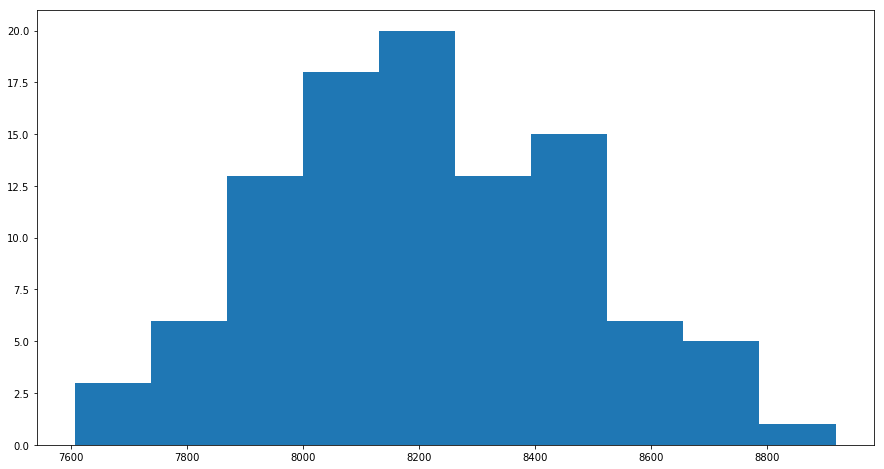

In [9]:
multi_run(100, reverse_sequence_mutation, PMX, 250)

 249    11.12634206 8250.61543042 8250.61543042 8250.61543042   0.00000000


 249    11.21727681 8039.02797963 8039.02797963 8039.02797963   0.00000000


 249    11.41303492 8057.96402318 8057.96402318 8057.96402318   0.00000000


 249    11.39407396 8500.72184408 8500.72184408 8500.72184408   0.00000000


 249    11.30541015 8353.77027634 8353.77027634 8353.77027634   0.00000000


 249    11.49181008 8497.83034300 8497.83034300 8497.83034300   0.00000000


 249    11.18523908 8870.59115342 8870.59115342 8870.59115342   0.00000000


 249    11.16546011 8518.96690579 8518.96690579 8518.96690579   0.00000000


 249    11.32921290 8118.15559517 8118.15559517 8118.15559517   0.00000000


 249    11.36333299 7750.28552636 7750.28552636 7750.28552636   0.00000000


 249    11.34014487 8436.61083544 8436.61083544 8436.61083544   0.00000000


 249    11.29267693 8117.87095367 8117.87095367 8117.87095367   0.00000000


 249    11.19935012 8056.09171657 8056.09171657 8056.09171657   0.00000000


 249    11.18365002 7731.83876011 7731.83876011 7731.83876011   0.00000000


 249    11.17491293 7991.59200056 7991.59200056 7991.59200056   0.00000000


 249    11.19075990 8253.88093309 8253.88093309 8253.88093309   0.00000000


 249    11.16960907 8376.35244812 8376.35244812 8376.35244812   0.00000000


 249    11.29517007 8588.26374961 8588.26374961 8588.26374961   0.00000000


 249    11.31344390 8288.05554225 8288.05554225 8288.05554225   0.00000000


 249    11.25289798 8201.67430921 8201.67430921 8201.67430921   0.00000000


 249    11.15767384 8071.52002887 8071.52002887 8071.52002887   0.00000000


 249    11.16535902 8183.88609862 8183.88609862 8183.88609862   0.00000000


 249    11.35105491 8131.72496765 8131.72496765 8131.72496765   0.00000000


 249    11.20576286 8852.32463338 8852.32463338 8852.32463338   0.00000000


 249    11.16982412 7769.87442840 7769.87442840 7769.87442840   0.00000000


 249    11.11364484 8091.82437932 8091.82437932 8091.82437932   0.00000000


 249    11.17555380 8197.64231077 8197.64231077 8197.64231077   0.00000000


 249    11.15556002 8214.82094701 8214.82094701 8214.82094701   0.00000000


 249    11.15897799 8942.40496185 8942.40496185 8942.40496185   0.00000000


 249    11.16777277 8100.58832259 8100.58832259 8100.58832259   0.00000000


 249    11.14723992 7966.24903144 7966.24903144 7966.24903144   0.00000000


 249    11.15217805 7925.07935942 7925.07935942 7925.07935942   0.00000000


 249    11.13927603 8427.19912592 8427.19912592 8427.19912592   0.00000000


 249    11.17978001 8111.54817724 8111.54817724 8111.54817724   0.00000000


 249    11.11726093 8134.98901494 8134.98901494 8134.98901494   0.00000000


 249    11.14781404 8587.92572248 8587.92572248 8587.92572248   0.00000000


 249    11.21036005 7932.09778529 7932.09778529 7932.09778529   0.00000000


 249    11.25519896 7956.59285253 7956.59285253 7956.59285253   0.00000000


 249    11.35083318 7870.58498031 7870.58498031 7870.58498031   0.00000000


 249    11.38058019 8039.18110137 8039.18110137 8039.18110137   0.00000000


 249    11.40640712 8102.36849223 8102.36849223 8102.36849223   0.00000000


 249    11.38450408 8233.77498555 8233.77498555 8233.77498555   0.00000000


 249    11.44372106 8193.78302013 8193.78302013 8193.78302013   0.00000000


 249    11.26557684 8192.53428326 8192.53428326 8192.53428326   0.00000000


 249    11.16821504 8132.74137951 8132.74137951 8132.74137951   0.00000000


 249    11.17162895 8000.44729167 8000.44729167 8000.44729167   0.00000000


 249    11.15138793 8517.58788140 8517.58788140 8517.58788140   0.00000000


 249    11.22807503 8133.78314557 8133.78314557 8133.78314557   0.00000000


 249    11.16440415 8307.74649728 8307.74649728 8307.74649728   0.00000000


 249    11.33482099 7881.07307548 7881.07307548 7881.07307548   0.00000000


 249    11.34039903 8347.64886035 8354.18973647 8400.30874206  17.35332329


 249    11.30797005 8403.36891851 8403.36891851 8403.36891851   0.00000000


 249    11.14644098 8218.26594025 8218.26594025 8218.26594025   0.00000000


 249    11.25836587 8312.35344425 8312.35344425 8312.35344425   0.00000000


 249    11.19827604 8066.97677137 8066.97677137 8066.97677137   0.00000000


 249    11.33882093 8517.21105611 8517.21105611 8517.21105611   0.00000000


 249    11.19406009 8166.47659476 8166.47659476 8166.47659476   0.00000000


 249    11.13774610 8289.16321360 8289.16321360 8289.16321360   0.00000000


 249    11.14461803 8018.46643086 8018.46643086 8018.46643086   0.00000000


 249    11.12267709 8414.95341166 8414.95341166 8414.95341166   0.00000000


 249    11.11892605 8396.14129327 8396.14129327 8396.14129327   0.00000000


 249    11.15669203 8449.01479508 8449.01479508 8449.01479508   0.00000000


 249    11.18818998 8156.83208817 8156.83208817 8156.83208817   0.00000000


 249    11.16129589 8492.31084891 8492.31084891 8492.31084891   0.00000000


 249    11.18118811 8171.18718678 8171.18718678 8171.18718678   0.00000000


 249    11.18555689 8241.59141759 8241.59141759 8241.59141759   0.00000000


 249    11.13251996 8211.66689829 8211.66689829 8211.66689829   0.00000000


 249    11.13545203 8171.87396658 8171.87396658 8171.87396658   0.00000000


 249    11.10634398 7917.61319146 7917.61319146 7917.61319146   0.00000000


 249    11.13842797 8301.43367609 8301.43367609 8301.43367609   0.00000000


 249    13.82577014 8266.05813131 8266.05813131 8266.05813131   0.00000000


 249    11.17074895 8439.37510028 8439.37510028 8439.37510028   0.00000000


 249    11.15290308 8192.04945396 8192.04945396 8192.04945396   0.00000000


 249    11.20690894 8203.01034102 8203.01034102 8203.01034102   0.00000000


 249    11.20472789 8397.03556462 8397.03556462 8397.03556462   0.00000000


 249    11.17878604 8035.42012563 8035.42012563 8035.42012563   0.00000000


 249    11.18873405 8074.26033876 8074.26033876 8074.26033876   0.00000000


 249    11.16691709 7955.76836705 7955.76836705 7955.76836705   0.00000000


 249    11.16275287 8305.50526047 8305.50526047 8305.50526047   0.00000000


 249    11.17746019 8485.23162793 8485.23162793 8485.23162793   0.00000000


 249    11.17425299 7992.69483427 7992.69483427 7992.69483427   0.00000000


 249    11.13202119 8087.21766388 8087.21766388 8087.21766388   0.00000000


 249    11.15574598 7932.74878977 7932.74878977 7932.74878977   0.00000000


 249    11.14973211 8258.48002648 8258.48002648 8258.48002648   0.00000000


 249    11.15584087 7679.15249700 7679.15249700 7679.15249700   0.00000000


 249    11.18955612 8755.29571390 8755.29571390 8755.29571390   0.00000000


 249    11.21267390 8007.20688021 8007.20688021 8007.20688021   0.00000000


 249    11.16464901 7953.39953277 7953.39953277 7953.39953277   0.00000000


 249    11.19237304 8393.96122768 8393.96122768 8393.96122768   0.00000000


 249    11.18220496 8066.61977188 8073.18347573 8092.25924003  11.18962321


 249    11.20344496 7901.20079826 7901.20079826 7901.20079826   0.00000000


 249    11.20230603 8124.78572211 8124.78572211 8124.78572211   0.00000000


 249    11.14757800 8188.06886968 8188.06886968 8188.06886968   0.00000000


 249    11.15701509 8051.06065064 8051.06065064 8051.06065064   0.00000000


 249    11.13992691 7885.51632942 7885.51632942 7885.51632942   0.00000000


 249    11.18059492 7962.36649546 7962.36649546 7962.36649546   0.00000000


 249    11.24428487 8356.44075110 8356.44075110 8356.44075110   0.00000000


 249    11.17886996 7889.54475674 7889.54475674 7889.54475674   0.00000000


 249    11.09878492 8340.81558794 8340.81558794 8340.81558794   0.00000000


 249    11.15303493 8267.38800957 8267.38800957 8267.38800957   0.00000000



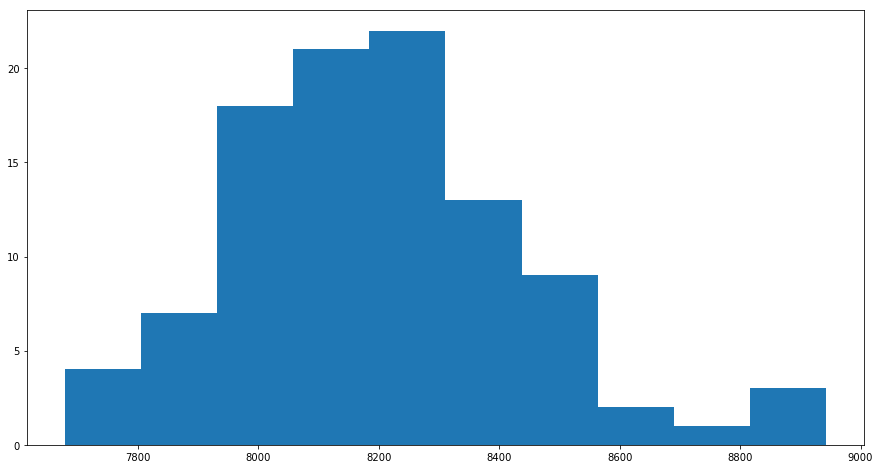

In [10]:
multi_run(100, reverse_sequence_mutation, PPX, 250)

 249     8.14189196 7932.99594041 7932.99594041 7932.99594041   0.00000000


 249     8.09143114 8162.63433156 8162.63433156 8162.63433156   0.00000000


 249     8.14935112 8409.98569649 8409.98569649 8409.98569649   0.00000000


 249     8.09060407 8443.33627849 8443.33627849 8443.33627849   0.00000000


 249     8.16113591 8149.88558158 8149.88558158 8149.88558158   0.00000000


 249     8.19678187 8012.10012096 8012.10012096 8012.10012096   0.00000000


 249     8.10907102 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249     8.20602608 8020.93869994 8020.93869994 8020.93869994   0.00000000


 249     8.15629697 8742.38453126 8742.38453126 8742.38453126   0.00000000


 249     8.14297104 7870.29017857 7870.29017857 7870.29017857   0.00000000


 249     8.19311380 7809.31324813 7809.31324813 7809.31324813   0.00000000


 249     8.18353009 8447.00302337 8447.00302337 8447.00302337   0.00000000


 249     8.13857198 7791.34580925 7791.34580925 7791.34580925   0.00000000


 249     8.17093706 8315.27950100 8315.27950100 8315.27950100   0.00000000


 249     8.25805902 8045.62869439 8045.62869439 8045.62869439   0.00000000


 249     8.10972905 8183.96564211 8183.96564211 8183.96564211   0.00000000


 249     8.24067187 8498.39542567 8498.39542567 8498.39542567   0.00000000


 249     8.29894900 8584.24953806 8584.24953806 8584.24953806   0.00000000


 249     8.14972210 8404.53558887 8404.53558887 8404.53558887   0.00000000


 249     8.10129881 8741.09073270 8741.09073270 8741.09073270   0.00000000


 249     8.30300808 8089.31448127 8089.31448127 8089.31448127   0.00000000


 249     8.25210690 8029.22971691 8029.22971691 8029.22971691   0.00000000


 249     8.17369699 8220.42015505 8220.42015505 8220.42015505   0.00000000


 249     8.15307617 8187.41686404 8187.41686404 8187.41686404   0.00000000


 249     8.32314610 8267.12203481 8267.12203481 8267.12203481   0.00000000


 249     8.23752093 8039.23318593 8039.23318593 8039.23318593   0.00000000


 249     8.28419805 8459.67041696 8459.67041696 8459.67041696   0.00000000


 249     8.17421794 8240.44761550 8240.44761550 8240.44761550   0.00000000


 249     8.20736194 8087.14377704 8087.14377704 8087.14377704   0.00000000


 249     8.19603014 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249     8.21744514 8414.67611647 8414.67611647 8414.67611647   0.00000000


 249     8.13486290 8312.85827436 8312.85827436 8312.85827436   0.00000000


 249     8.14820695 8083.10205616 8083.10205616 8083.10205616   0.00000000


 249     8.12081718 8487.42360745 8487.42360745 8487.42360745   0.00000000


 249     8.16330504 8266.56615816 8266.56615816 8266.56615816   0.00000000


 249     8.18480897 8467.68459358 8467.68459358 8467.68459358   0.00000000


 249     8.19855499 8054.92433557 8054.92433557 8054.92433557   0.00000000


 249     8.11396790 8368.36474277 8368.36474277 8368.36474277   0.00000000


 249     8.16702700 8224.20906779 8224.20906779 8224.20906779   0.00000000


 249     8.16597605 7925.29791105 7925.29791105 7925.29791105   0.00000000


 249     8.14423895 7917.67336528 7917.67336528 7917.67336528   0.00000000


 249     8.05796003 8325.80523947 8325.80523947 8325.80523947   0.00000000


 249     8.15560818 7999.07851325 7999.07851325 7999.07851325   0.00000000


 249     8.13580990 7911.72720251 7911.72720251 7911.72720251   0.00000000


 249     8.14079714 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249     8.16022897 7685.01443634 7685.01443634 7685.01443634   0.00000000


 249     8.18619609 8090.74277072 8090.74277072 8090.74277072   0.00000000


 249     8.07837296 7798.38092691 7798.38092691 7798.38092691   0.00000000


 249     8.12997103 7961.76583884 7961.76583884 7961.76583884   0.00000000


 249     8.13369298 8173.42050708 8173.42050708 8173.42050708   0.00000000


 249     8.11818600 8315.57860060 8315.57860060 8315.57860060   0.00000000


 249     8.20430803 8082.56786283 8082.56786283 8082.56786283   0.00000000


 249     8.31797290 8013.08266339 8013.08266339 8013.08266339   0.00000000


 249     8.13170505 7996.76483771 7996.76483771 7996.76483771   0.00000000


 249     8.61914992 8232.42354556 8232.42354556 8232.42354556   0.00000000


 249     8.22072196 8253.80628090 8253.80628090 8253.80628090   0.00000000


 249     8.22024488 8206.52861843 8206.52861843 8206.52861843   0.00000000


 249     8.29479599 8011.31496529 8011.31496529 8011.31496529   0.00000000


 249     8.27851796 8690.10483185 8690.10483185 8690.10483185   0.00000000


 249     8.20015717 8209.33242746 8209.33242746 8209.33242746   0.00000000


 249     8.32340503 8659.81334823 8659.81334823 8659.81334823   0.00000000


 249     8.26137900 8106.05922420 8106.05922420 8106.05922420   0.00000000


 249     8.21890903 8092.94186007 8092.94186007 8092.94186007   0.00000000


 249     8.23806906 7838.52257127 7838.52257127 7838.52257127   0.00000000


 249     8.31703997 7744.40685673 7744.40685673 7744.40685673   0.00000000


 249     8.28962898 7943.31199607 7943.31199607 7943.31199607   0.00000000


 249     8.27957392 7820.22440828 7820.22440828 7820.22440828   0.00000000


 249     8.68842101 7735.80047160 7735.80047160 7735.80047160   0.00000000


 249     8.46138597 8157.76633527 8157.76633527 8157.76633527   0.00000000


 249     8.32041693 8349.20191070 8349.20191070 8349.20191070   0.00000000


 249     8.32525802 7849.39517689 7849.39517689 7849.39517689   0.00000000


 249     8.10347605 8078.09055367 8078.09055367 8078.09055367   0.00000000


 249     8.12627411 8289.09787814 8289.09787814 8289.09787814   0.00000000


 249     8.14240909 8219.61316146 8219.61316146 8219.61316146   0.00000000


 249     8.15325403 8129.10350763 8129.10350763 8129.10350763   0.00000000


 249     8.11303806 7990.11999558 7990.11999558 7990.11999558   0.00000000


 249     8.16455412 8073.80205349 8073.80205349 8073.80205349   0.00000000


 249     8.10354686 7841.49610140 7841.49610140 7841.49610140   0.00000000


 249     8.12751698 8516.32421667 8516.32421667 8516.32421667   0.00000000


 249     8.23397899 7866.04229961 7866.04229961 7866.04229961   0.00000000


 249     8.15611982 8343.20791290 8343.20791290 8343.20791290   0.00000000


 249     8.08881807 8358.56846138 8358.56846138 8358.56846138   0.00000000


 249     8.16343808 8032.07202836 8032.07202836 8032.07202836   0.00000000


 249     8.33998704 8017.43080899 8017.43080899 8017.43080899   0.00000000


 249     8.46418190 8390.61223792 8390.61223792 8390.61223792   0.00000000


 249     8.31619883 7796.68933373 7796.68933373 7796.68933373   0.00000000


 249     8.17029405 8605.15729954 8605.15729954 8605.15729954   0.00000000


 249     8.10632896 8297.85682782 8297.85682782 8297.85682782   0.00000000


 249     8.16414809 8046.26947786 8046.26947786 8046.26947786   0.00000000


 249     8.17893410 8012.33112627 8012.33112627 8012.33112627   0.00000000


 249     8.14598012 8316.05728753 8316.05728753 8316.05728753   0.00000000


 249     8.05874801 8058.11358515 8058.11358515 8058.11358515   0.00000000


 249     8.15899014 7741.48289490 7741.48289490 7741.48289490   0.00000000


 249     8.10771608 8331.06486058 8331.06486058 8331.06486058   0.00000000


 249     8.14697194 8269.24329546 8269.24329546 8269.24329546   0.00000000


 249     8.14699292 8336.24594171 8336.24594171 8336.24594171   0.00000000


 249     8.16238093 7864.20627108 7864.20627108 7864.20627108   0.00000000


 249     8.05709314 8170.77518513 8170.77518513 8170.77518513   0.00000000


 249     8.16608596 8330.00896548 8330.00896548 8330.00896548   0.00000000


 249     8.11932611 8249.00916169 8249.00916169 8249.00916169   0.00000000


 249     8.15224600 8246.42415214 8246.42415214 8246.42415214   0.00000000


 249     8.18074703 8104.49380581 8104.49380581 8104.49380581   0.00000000


 249     8.15293407 8097.69061435 8097.69061435 8097.69061435   0.00000000


 249     8.09483504 8175.53618094 8175.53618094 8175.53618094   0.00000000


 249     8.14321208 8039.50146676 8039.50146676 8039.50146676   0.00000000


 249     8.13159013 7959.62493349 7959.62493349 7959.62493349   0.00000000


 249     8.13205099 8117.58164704 8117.58164704 8117.58164704   0.00000000


 249     8.04329681 8665.72170853 8665.72170853 8665.72170853   0.00000000


 249     8.14467192 7875.06315173 7875.06315173 7875.06315173   0.00000000


 249     8.11247396 8171.59072191 8171.59072191 8171.59072191   0.00000000


 249     8.12531495 8663.12628203 8663.12628203 8663.12628203   0.00000000


 249     8.12785506 8575.44129731 8575.44129731 8575.44129731   0.00000000


 249     8.13216305 7982.50070159 7982.50070159 7982.50070159   0.00000000


 249     8.09458113 8122.31796385 8122.31796385 8122.31796385   0.00000000


 249     8.13959098 8180.41827973 8180.41827973 8180.41827973   0.00000000


 249     8.08842897 7735.79838522 7735.79838522 7735.79838522   0.00000000


 249     8.14684892 8152.99594412 8152.99594412 8152.99594412   0.00000000


 249     8.15432000 7899.20904221 7899.20904221 7899.20904221   0.00000000


 249     8.18432093 8427.02853568 8427.02853568 8427.02853568   0.00000000


 249     8.08848000 8235.43038475 8235.43038475 8235.43038475   0.00000000


 249     8.12583303 8356.45913624 8356.45913624 8356.45913624   0.00000000


 249     8.12788105 7879.16918478 7879.16918478 7879.16918478   0.00000000


 249     8.14145613 8482.42584403 8482.42584403 8482.42584403   0.00000000


 249     8.06900787 8268.99271374 8268.99271374 8268.99271374   0.00000000


 249     8.15521789 7890.65382663 7890.65382663 7890.65382663   0.00000000


 249     8.10991693 7619.15310138 7619.15310138 7619.15310138   0.00000000


 249     8.11795092 8401.50391888 8401.50391888 8401.50391888   0.00000000


 249     8.15940809 8465.45904589 8465.45904589 8465.45904589   0.00000000


 249     8.12409210 8530.72545289 8530.72545289 8530.72545289   0.00000000


 249     8.06309795 8015.85967058 8015.85967058 8015.85967058   0.00000000


 249     8.15558791 8050.54873595 8050.54873595 8050.54873595   0.00000000


 249     8.14090800 8431.75414335 8431.75414335 8431.75414335   0.00000000


 249     8.15514088 8630.97262779 8630.97262779 8630.97262779   0.00000000


 249     8.16725802 8066.42080621 8066.42080621 8066.42080621   0.00000000


 249     8.13748479 8515.99587498 8515.99587498 8515.99587498   0.00000000


 249     8.09868598 8241.10394965 8241.10394965 8241.10394965   0.00000000


 249     8.14109898 8097.93831268 8097.93831268 8097.93831268   0.00000000


 249     8.13269401 8243.93008404 8243.93008404 8243.93008404   0.00000000


 249     8.12898207 8078.41319367 8078.41319367 8078.41319367   0.00000000


 249     8.05920410 7998.46116437 7998.46116437 7998.46116437   0.00000000


 249     8.15328288 8311.54639517 8311.54639517 8311.54639517   0.00000000


 249     8.08900380 7797.97640670 7797.97640670 7797.97640670   0.00000000


 249     8.15074992 8370.28250607 8370.28250607 8370.28250607   0.00000000


 249     8.16384411 8373.88171117 8373.88171117 8373.88171117   0.00000000


 249     8.13695908 8302.67200649 8302.67200649 8302.67200649   0.00000000


 249     8.06447315 8457.28491837 8457.28491837 8457.28491837   0.00000000


 249     8.15320897 7983.24352168 7983.24352168 7983.24352168   0.00000000


 249     8.13356900 8115.63202028 8115.63202028 8115.63202028   0.00000000


 249     8.16125393 8118.07104705 8118.07104705 8118.07104705   0.00000000


 249     8.16317105 8412.57887026 8412.57887026 8412.57887026   0.00000000


 249     8.15190506 8274.38393071 8274.38393071 8274.38393071   0.00000000


 249     8.10443711 8090.83377155 8090.83377155 8090.83377155   0.00000000


 249     8.12381792 8709.55493987 8709.55493987 8709.55493987   0.00000000


 249     8.12698388 7983.61446988 7983.61446988 7983.61446988   0.00000000


 249     8.17518282 7896.65383356 7896.65383356 7896.65383356   0.00000000


 249     8.07962704 8264.41255207 8264.41255207 8264.41255207   0.00000000


 249     8.62120986 7929.09694667 7929.09694667 7929.09694667   0.00000000


 249    10.71355414 8220.82547855 8220.82547855 8220.82547855   0.00000000


 249     8.13610005 7924.08469889 7924.08469889 7924.08469889   0.00000000


 249     8.10534191 8511.97836139 8511.97836139 8511.97836139   0.00000000


 249     8.14042115 8376.45461485 8376.45461485 8376.45461485   0.00000000


 249     8.16786599 8139.04440192 8139.04440192 8139.04440192   0.00000000


 249     8.17228413 8551.61698090 8551.61698090 8551.61698090   0.00000000


 249     8.18383598 8375.79456121 8375.79456121 8375.79456121   0.00000000


 249     8.15036511 8000.41773828 8000.41773828 8000.41773828   0.00000000


 249     8.14250612 8224.19393097 8224.19393097 8224.19393097   0.00000000


 249     8.11659908 8271.28166006 8271.28166006 8271.28166006   0.00000000


 249     8.15297508 8024.20103715 8024.20103715 8024.20103715   0.00000000


 249     8.15424085 8143.98329517 8143.98329517 8143.98329517   0.00000000


 249     8.11004400 8118.26807197 8118.26807197 8118.26807197   0.00000000


 249     8.16445708 8057.62005093 8057.62005093 8057.62005093   0.00000000


 249     8.14708209 8564.64888380 8564.64888380 8564.64888380   0.00000000


 249     8.14105988 7991.27243431 7991.27243431 7991.27243431   0.00000000


 249     8.09465313 7955.59610517 7955.59610517 7955.59610517   0.00000000


 249     8.16341186 8001.08456880 8001.08456880 8001.08456880   0.00000000


 249     8.10231686 8736.30860209 8736.30860209 8736.30860209   0.00000000


 249     8.12148309 8457.45164190 8457.45164190 8457.45164190   0.00000000


 249     8.22553396 8716.48220692 8716.48220692 8716.48220692   0.00000000


 249     8.31796312 8133.23942940 8133.23942940 8133.23942940   0.00000000


 249     8.16187000 8387.68143452 8387.68143452 8387.68143452   0.00000000


 249     8.29390693 8185.32779962 8185.32779962 8185.32779962   0.00000000


 249     8.18323612 8247.33419550 8247.33419550 8247.33419550   0.00000000


 249     8.25734401 8231.11340277 8231.11340277 8231.11340277   0.00000000


 249     8.01382399 8252.39199439 8252.39199439 8252.39199439   0.00000000


 249     8.08617687 8208.81405849 8208.81405849 8208.81405849   0.00000000


 249     8.01780415 8309.02680866 8309.02680866 8309.02680866   0.00000000


 249     8.06915307 7930.79500979 7930.79500979 7930.79500979   0.00000000


 249     8.07213402 8453.93834547 8453.93834547 8453.93834547   0.00000000


 249     7.96786594 7891.52517708 7891.52517708 7891.52517708   0.00000000


 249     7.99976707 8430.43754247 8430.43754247 8430.43754247   0.00000000


 249     8.06075907 7966.38641791 7966.38641791 7966.38641791   0.00000000


 249     8.02486014 8121.88357372 8121.88357372 8121.88357372   0.00000000


 249     8.05888104 8644.59588243 8644.59588243 8644.59588243   0.00000000


 249     8.07240891 8047.21763004 8047.21763004 8047.21763004   0.00000000


 249     7.99114919 8019.56545437 8019.56545437 8019.56545437   0.00000000


 249     7.99618387 8549.89320130 8549.89320130 8549.89320130   0.00000000


 249     8.07560396 8220.68135237 8220.68135237 8220.68135237   0.00000000


 249     8.03020000 8171.74613803 8171.74613803 8171.74613803   0.00000000


 249     8.02023697 8058.33386250 8058.33386250 8058.33386250   0.00000000


 249     7.97699094 7867.39089706 7867.39089706 7867.39089706   0.00000000


 249     8.09061122 8242.32941214 8242.32941214 8242.32941214   0.00000000


 249     8.00215006 7857.60284304 7857.60284304 7857.60284304   0.00000000


 249     8.04154897 7982.90556012 7982.90556012 7982.90556012   0.00000000


 249     8.06090713 8552.63006759 8552.63006759 8552.63006759   0.00000000


 249     8.06746197 8290.97181661 8290.97181661 8290.97181661   0.00000000


 249     8.21885800 8402.78203980 8402.78203980 8402.78203980   0.00000000


 249     8.26371098 8194.81434141 8194.81434141 8194.81434141   0.00000000


 249     8.15197015 8631.96640481 8631.96640481 8631.96640481   0.00000000


 249     8.11321783 8142.41470006 8142.41470006 8142.41470006   0.00000000


 249     8.14693689 7954.17734994 7954.17734994 7954.17734994   0.00000000


 249     8.11119986 8074.82020266 8074.82020266 8074.82020266   0.00000000


 249     8.13514400 8297.68652781 8297.68652781 8297.68652781   0.00000000


 249     8.18369293 8025.90362692 8025.90362692 8025.90362692   0.00000000


 249     8.15618491 8439.26915661 8439.26915661 8439.26915661   0.00000000


 249     8.10234308 8368.54324483 8368.54324483 8368.54324483   0.00000000


 249     8.05039406 8252.45056149 8252.45056149 8252.45056149   0.00000000


 249     8.12003613 8392.41324094 8392.41324094 8392.41324094   0.00000000


 249     8.15665007 8080.74947816 8080.74947816 8080.74947816   0.00000000


 249     8.27371502 8247.47281661 8247.47281661 8247.47281661   0.00000000


 249     8.26736307 8818.32887524 8818.32887524 8818.32887524   0.00000000


 249     8.25245690 8151.75822231 8151.75822231 8151.75822231   0.00000000


 249     8.19239283 8598.58510348 8598.58510348 8598.58510348   0.00000000


 249     8.11220407 8005.36108393 8005.36108393 8005.36108393   0.00000000


 249     8.12400723 7731.98638200 7731.98638200 7731.98638200   0.00000000


 249     8.09735990 8273.34320440 8273.34320440 8273.34320440   0.00000000


 249     8.12050104 8391.49402531 8391.49402531 8391.49402531   0.00000000


 249     9.13291097 8281.34754531 8281.34754531 8281.34754531   0.00000000


 249     9.38499808 8252.88996889 8252.88996889 8252.88996889   0.00000000


 249     8.05727911 7729.50084541 7729.50084541 7729.50084541   0.00000000


 249     8.09173107 8124.97616361 8124.97616361 8124.97616361   0.00000000


 249     8.10109711 8470.17986407 8470.17986407 8470.17986407   0.00000000


 249     8.10823798 8169.82415856 8169.82415856 8169.82415856   0.00000000


 249     8.01015115 8077.71141387 8077.71141387 8077.71141387   0.00000000


 249     8.15993786 8495.21547751 8495.21547751 8495.21547751   0.00000000


 249     8.17035007 8272.51652698 8272.51652698 8272.51652698   0.00000000


 249     8.18987513 8263.55223335 8263.55223335 8263.55223335   0.00000000


 249     8.16575599 8136.99842045 8136.99842045 8136.99842045   0.00000000


 249     8.19788718 8504.96809036 8504.96809036 8504.96809036   0.00000000


 249     8.07690787 8227.58736689 8227.58736689 8227.58736689   0.00000000


 249     8.19483805 8203.35959775 8203.35959775 8203.35959775   0.00000000


 249     8.16697311 7669.61965726 7669.61965726 7669.61965726   0.00000000


 249     8.20882201 8228.27009610 8228.27009610 8228.27009610   0.00000000


 249     8.11492205 8137.50806170 8137.50806170 8137.50806170   0.00000000


 249     8.12213588 8183.48794098 8183.48794098 8183.48794098   0.00000000


 249     8.07872200 8687.15757168 8687.15757168 8687.15757168   0.00000000


 249     8.12724209 8022.26242628 8022.26242628 8022.26242628   0.00000000


 249     8.11159801 8553.26010374 8553.26010374 8553.26010374   0.00000000


 249     8.10206199 8042.77216191 8042.77216191 8042.77216191   0.00000000


 249     8.00647807 8488.54986587 8488.54986587 8488.54986587   0.00000000


 249     8.09586501 7895.85003846 7895.85003846 7895.85003846   0.00000000


 249     8.23533607 8338.75341165 8338.75341165 8338.75341165   0.00000000


 249     8.36533380 8793.18337104 8793.18337104 8793.18337104   0.00000000


 249     8.42748713 8447.59586852 8447.59586852 8447.59586852   0.00000000


 249     8.20334005 8704.39408573 8704.39408573 8704.39408573   0.00000000


 249     8.07247710 8354.40201800 8354.40201800 8354.40201800   0.00000000


 249     8.19050097 8235.45229260 8235.45229260 8235.45229260   0.00000000


 249     8.12191319 8415.90294397 8415.90294397 8415.90294397   0.00000000


 249     8.16851091 8304.60323657 8304.60323657 8304.60323657   0.00000000


 249     8.19789815 8157.55941139 8157.55941139 8157.55941139   0.00000000


 249     8.17262983 8303.37828302 8303.37828302 8303.37828302   0.00000000


 249     8.20241189 8181.47491652 8181.47491652 8181.47491652   0.00000000


 249     8.55865002 8203.85301319 8203.85301319 8203.85301319   0.00000000


 249     8.27146196 8067.04675565 8067.04675565 8067.04675565   0.00000000


 249     8.29992390 8350.29441016 8350.29441016 8350.29441016   0.00000000


 249     8.26560307 8286.27023630 8286.27023630 8286.27023630   0.00000000


 249     8.27772212 8193.16225984 8193.16225984 8193.16225984   0.00000000


 249     8.23258185 8243.44940299 8243.44940299 8243.44940299   0.00000000


 249     8.26475596 8206.25739644 8206.25739644 8206.25739644   0.00000000


 249     8.26404095 8486.99609085 8486.99609085 8486.99609085   0.00000000


 249     8.26041698 7910.64909227 7910.64909227 7910.64909227   0.00000000


 249     8.33695412 8315.03289584 8315.03289584 8315.03289584   0.00000000


 249     8.31544995 8234.27025008 8234.27025008 8234.27025008   0.00000000


 249     8.20422602 8280.44229638 8280.44229638 8280.44229638   0.00000000


 249     8.29489803 8411.85435115 8411.85435115 8411.85435115   0.00000000


 249     8.44609404 7965.67484765 7965.67484765 7965.67484765   0.00000000


 249     8.28817892 8067.45606373 8067.45606373 8067.45606373   0.00000000


 249     8.26679492 8076.41634167 8076.41634167 8076.41634167   0.00000000


 249     8.28005981 8048.84186583 8048.84186583 8048.84186583   0.00000000


 249     8.24445009 8485.81996967 8485.81996967 8485.81996967   0.00000000


 249     8.30869317 8279.00598268 8279.00598268 8279.00598268   0.00000000


 249     8.41535306 8205.27755342 8205.27755342 8205.27755342   0.00000000


 249     8.17039609 8494.35780363 8494.35780363 8494.35780363   0.00000000


 249     8.20745277 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249     8.17089701 8071.84002775 8071.84002775 8071.84002775   0.00000000


 249    11.07280612 8258.91543510 8258.91543510 8258.91543510   0.00000000


 249     9.64490986 8272.61992138 8272.61992138 8272.61992138   0.00000000


 249     8.09434605 8058.50189558 8058.50189558 8058.50189558   0.00000000


 249     8.17041111 8147.70754009 8147.70754009 8147.70754009   0.00000000


 249     8.16359210 8382.58019161 8382.58019161 8382.58019161   0.00000000


 249     8.14150500 8321.65734670 8321.65734670 8321.65734670   0.00000000


 249     8.15855289 8218.58703394 8218.58703394 8218.58703394   0.00000000


 249     8.15505910 8230.46046294 8230.46046294 8230.46046294   0.00000000


 249     8.12098312 7978.39464712 7978.39464712 7978.39464712   0.00000000


 249     8.16613078 8473.92836532 8473.92836532 8473.92836532   0.00000000


 249     8.15971398 8387.41500942 8387.41500942 8387.41500942   0.00000000


 249     8.16667199 8613.17354712 8613.17354712 8613.17354712   0.00000000


 249     8.06678486 8199.44266797 8199.44266797 8199.44266797   0.00000000


 249     8.14507008 8413.22664893 8413.22664893 8413.22664893   0.00000000


 249     8.16492605 8083.51389724 8083.51389724 8083.51389724   0.00000000


 249     8.14465594 8352.01334515 8352.01334515 8352.01334515   0.00000000


 249     8.36091900 8262.09683038 8262.09683038 8262.09683038   0.00000000


 249     8.41560102 8174.41943241 8174.41943241 8174.41943241   0.00000000


 249     8.27940893 8109.52929543 8109.52929543 8109.52929543   0.00000000


 249     8.38241410 8029.21190870 8029.21190870 8029.21190870   0.00000000


 249     8.31125998 9058.14930067 9058.14930067 9058.14930067   0.00000000


 249     8.45217085 7889.54051182 7889.54051182 7889.54051182   0.00000000


 249     8.38216615 8034.49528887 8034.49528887 8034.49528887   0.00000000


 249     8.20990992 7805.16134718 7805.16134718 7805.16134718   0.00000000


 249     8.05772781 8067.50403124 8067.50403124 8067.50403124   0.00000000


 249     8.18582702 8145.22820821 8145.22820821 8145.22820821   0.00000000


 249     8.24377179 8493.80172414 8493.80172414 8493.80172414   0.00000000


 249     8.26209688 8078.61634116 8078.61634116 8078.61634116   0.00000000


 249     8.28087687 8256.18238039 8256.18238039 8256.18238039   0.00000000


 249     8.27594495 8311.20036616 8311.20036616 8311.20036616   0.00000000


 249     8.29248500 8039.74415605 8039.74415605 8039.74415605   0.00000000


 249     8.29168010 8124.93258031 8124.93258031 8124.93258031   0.00000000


 249     8.34188294 8243.42690710 8243.42690710 8243.42690710   0.00000000


 249     8.16301107 8394.97784720 8394.97784720 8394.97784720   0.00000000


 249     8.14668894 8290.13206284 8290.13206284 8290.13206284   0.00000000


 249     8.12355709 8547.02336575 8547.02336575 8547.02336575   0.00000000


 249     8.08505607 7837.26492682 7837.26492682 7837.26492682   0.00000000


 249     8.27062893 7967.67528698 7967.67528698 7967.67528698   0.00000000


 249     8.30020785 8087.52590484 8087.52590484 8087.52590484   0.00000000


 249     8.28494310 8310.69858047 8310.69858047 8310.69858047   0.00000000


 249     8.16467690 8268.86718625 8268.86718625 8268.86718625   0.00000000


 249     8.12283683 8115.22275567 8115.22275567 8115.22275567   0.00000000


 249     8.08306813 8529.50538294 8529.50538294 8529.50538294   0.00000000


 249     8.09629488 8323.07702187 8323.07702187 8323.07702187   0.00000000


 249     8.11527896 8139.65002682 8139.65002682 8139.65002682   0.00000000


 249     8.06806493 8626.28146176 8626.28146176 8626.28146176   0.00000000


 249     8.05328798 8167.34563918 8167.34563918 8167.34563918   0.00000000


 249     8.09739590 8101.63724181 8101.63724181 8101.63724181   0.00000000


 249     8.09295988 8588.71470386 8588.71470386 8588.71470386   0.00000000


 249     8.10361481 8383.39364035 8383.39364035 8383.39364035   0.00000000


 249     8.10378885 8134.64056808 8134.64056808 8134.64056808   0.00000000


 249     8.12845087 7777.33231128 7777.33231128 7777.33231128   0.00000000


 249     8.10583210 8544.30190171 8544.30190171 8544.30190171   0.00000000


 249     8.14400387 7903.27584414 7903.27584414 7903.27584414   0.00000000


 249     8.14614511 8470.58802739 8470.58802739 8470.58802739   0.00000000


 249     8.18769002 8015.62949360 8015.62949360 8015.62949360   0.00000000


 249     8.07073593 8108.91868275 8108.91868275 8108.91868275   0.00000000


 249     8.14094806 8956.29611015 8956.29611015 8956.29611015   0.00000000


 249     9.25791001 8523.08621395 8523.08621395 8523.08621395   0.00000000


 249     8.37396097 8179.82144669 8179.82144669 8179.82144669   0.00000000


 249     8.28697014 8936.10231491 8936.10231491 8936.10231491   0.00000000


 249     8.13115215 8248.15654734 8248.15654734 8248.15654734   0.00000000


 249     8.03689599 8022.76585567 8022.76585567 8022.76585567   0.00000000


 249     8.10532117 8138.16327302 8138.16327302 8138.16327302   0.00000000


 249     8.06589198 8475.99937170 8475.99937170 8475.99937170   0.00000000


 249     8.14078403 8636.31148982 8636.31148982 8636.31148982   0.00000000


 249     8.12457705 7774.24236434 7774.24236434 7774.24236434   0.00000000


 249     8.09261990 8192.90183362 8192.90183362 8192.90183362   0.00000000


 249     8.05833387 8293.03010959 8293.03010959 8293.03010959   0.00000000


 249     8.10589600 8691.97668051 8691.97668051 8691.97668051   0.00000000


 249     8.09069800 8641.21028752 8641.21028752 8641.21028752   0.00000000


 249     8.10589194 8018.58661646 8018.58661646 8018.58661646   0.00000000


 249     8.12205315 8559.86823379 8559.86823379 8559.86823379   0.00000000


 249     8.10895109 8325.81293331 8325.81293331 8325.81293331   0.00000000


 249     8.04999995 8177.54998567 8177.54998567 8177.54998567   0.00000000


 249     8.32662702 8015.77739144 8015.77739144 8015.77739144   0.00000000


 249     8.11485291 8224.69929362 8224.69929362 8224.69929362   0.00000000


 249     8.10311913 8321.05501837 8321.05501837 8321.05501837   0.00000000


 249     8.02634907 8028.81879810 8028.81879810 8028.81879810   0.00000000


 249     8.14396119 8656.74652742 8656.74652742 8656.74652742   0.00000000


 249     8.07765508 8697.30343451 8697.30343451 8697.30343451   0.00000000


 249     8.12063193 8622.10437999 8622.10437999 8622.10437999   0.00000000


 249     8.11409807 8379.34184112 8379.34184112 8379.34184112   0.00000000


 249     8.15069890 7824.13917724 7824.13917724 7824.13917724   0.00000000


 249     8.05121207 8562.16937300 8562.16937300 8562.16937300   0.00000000


 249     8.09718800 8380.97115940 8380.97115940 8380.97115940   0.00000000


 249     8.07901716 8561.09948525 8561.09948525 8561.09948525   0.00000000


 249     8.11540914 8627.03000055 8627.03000055 8627.03000055   0.00000000


 249     8.06945086 8335.56067059 8335.56067059 8335.56067059   0.00000000


 249     8.13536692 7744.04341789 7744.04341789 7744.04341789   0.00000000


 249     8.07621098 8242.01853595 8242.01853595 8242.01853595   0.00000000


 249     8.09144378 7977.38941854 7977.38941854 7977.38941854   0.00000000


 249     8.09588003 8360.17986695 8360.17986695 8360.17986695   0.00000000


 249     8.10082006 8240.58620869 8240.58620869 8240.58620869   0.00000000


 249     8.02863407 8367.27899029 8367.27899029 8367.27899029   0.00000000


 249     8.13070798 8299.22006386 8299.22006386 8299.22006386   0.00000000


 249     8.14935398 7606.94844359 7606.94844359 7606.94844359   0.00000000


 249     8.11966014 8225.50058174 8225.50058174 8225.50058174   0.00000000


 249     8.12130904 8102.98256615 8102.98256615 8102.98256615   0.00000000


 249     8.12451816 8432.21863183 8432.21863183 8432.21863183   0.00000000


 249     8.05821109 8310.99729954 8310.99729954 8310.99729954   0.00000000


 249     8.09319305 8652.47737584 8652.47737584 8652.47737584   0.00000000


 249     8.12163997 7872.56592426 7872.56592426 7872.56592426   0.00000000


 249     8.23864603 8895.11800532 8895.11800532 8895.11800532   0.00000000


 249     8.13429999 8202.99465976 8202.99465976 8202.99465976   0.00000000


 249     8.20735502 8112.43040783 8112.43040783 8112.43040783   0.00000000


 249     8.17152286 8055.67620031 8055.67620031 8055.67620031   0.00000000


 249     8.21173882 7918.09028926 7918.09028926 7918.09028926   0.00000000


 249     8.24694681 8267.15951526 8267.15951526 8267.15951526   0.00000000


 249     8.16905093 8397.53622285 8397.53622285 8397.53622285   0.00000000


 249     8.01880693 8424.03703368 8424.03703368 8424.03703368   0.00000000


 249     8.11064196 7992.34356735 7992.34356735 7992.34356735   0.00000000


 249     8.09359717 8225.44348942 8225.44348942 8225.44348942   0.00000000


 249     8.09606600 8424.10167830 8424.10167830 8424.10167830   0.00000000


 249     8.11610603 8458.22817604 8458.22817604 8458.22817604   0.00000000


 249     8.11786294 7808.00881712 7808.00881712 7808.00881712   0.00000000


 249     8.06798792 8342.75697320 8342.75697320 8342.75697320   0.00000000


 249     8.10970497 7606.94844359 7606.94844359 7606.94844359   0.00000000


 249     8.10319185 8278.08599812 8278.08599812 8278.08599812   0.00000000


 249     8.07386303 8094.76528525 8094.76528525 8094.76528525   0.00000000


 249     8.03769517 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249     8.12238383 8477.10163988 8477.10163988 8477.10163988   0.00000000


 249     8.10705590 8071.21955650 8071.21955650 8071.21955650   0.00000000


 249     8.11292791 8299.08293703 8299.08293703 8299.08293703   0.00000000


 249     8.13322401 8347.14788638 8347.14788638 8347.14788638   0.00000000


 249     8.08923912 8185.78754205 8185.78754205 8185.78754205   0.00000000


 249     8.05657911 8458.31848033 8458.31848033 8458.31848033   0.00000000


 249     8.15988398 8041.44332162 8041.44332162 8041.44332162   0.00000000


 249     8.09800506 8092.45233715 8092.45233715 8092.45233715   0.00000000


 249     8.08967400 7840.06248295 7840.06248295 7840.06248295   0.00000000


 249     8.10666418 8813.49012375 8813.49012375 8813.49012375   0.00000000


 249     8.11405420 8257.42664975 8257.42664975 8257.42664975   0.00000000


 249     8.08464789 8321.75939261 8321.75939261 8321.75939261   0.00000000


 249     8.10029697 8082.05615745 8082.05615745 8082.05615745   0.00000000


 249     8.09346485 8343.26471538 8343.26471538 8343.26471538   0.00000000


 249     8.08571410 8035.39042633 8035.39042633 8035.39042633   0.00000000


 249     8.04929304 7922.47598394 7922.47598394 7922.47598394   0.00000000


 249     8.10364985 8451.05400095 8451.05400095 8451.05400095   0.00000000


 249     8.10212207 7855.42342916 7855.42342916 7855.42342916   0.00000000


 249     8.08989096 8219.44546703 8219.44546703 8219.44546703   0.00000000


 249     8.19081402 7875.97701175 7875.97701175 7875.97701175   0.00000000


 249     8.12928319 7877.98721329 7877.98721329 7877.98721329   0.00000000


 249     8.06687117 7872.13606246 7872.13606246 7872.13606246   0.00000000


 249     8.15123010 7877.28778013 7877.28778013 7877.28778013   0.00000000


 249     8.14457297 8132.69854662 8132.69854662 8132.69854662   0.00000000


 249     8.14377785 8388.68371655 8388.68371655 8388.68371655   0.00000000


 249     8.11541414 8290.23511700 8290.23511700 8290.23511700   0.00000000


 249     8.11539006 8263.28058151 8263.28058151 8263.28058151   0.00000000


 249     8.06808615 8572.00739679 8572.00739679 8572.00739679   0.00000000


 249     8.11353803 7975.46878788 7975.46878788 7975.46878788   0.00000000


 249     8.10583901 8345.69356133 8345.69356133 8345.69356133   0.00000000


 249     8.08650208 8043.23333356 8043.23333356 8043.23333356   0.00000000


 249     8.12847304 8605.70272968 8605.70272968 8605.70272968   0.00000000


 249     8.23607993 8508.93642159 8508.93642159 8508.93642159   0.00000000


 249     8.19740510 8240.81620923 8240.81620923 8240.81620923   0.00000000


 249     8.15544701 8341.34837317 8341.34837317 8341.34837317   0.00000000


 249     8.13240504 8043.68023681 8043.68023681 8043.68023681   0.00000000


 249     8.10345101 8158.36235824 8158.36235824 8158.36235824   0.00000000


 249     8.05773091 8038.93622842 8038.93622842 8038.93622842   0.00000000


 249     8.12022400 8237.80299065 8237.80299065 8237.80299065   0.00000000


 249     8.09777999 8675.68674710 8675.68674710 8675.68674710   0.00000000


 249     8.22221017 8304.48397756 8304.48397756 8304.48397756   0.00000000


 249     8.12575507 8410.30399265 8410.30399265 8410.30399265   0.00000000


 249     8.10620904 8115.25289139 8115.25289139 8115.25289139   0.00000000


 249     8.09096217 8404.46825304 8404.46825304 8404.46825304   0.00000000


 249     8.09299612 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249     8.22258282 8031.47381191 8031.47381191 8031.47381191   0.00000000


 249     8.25836492 8249.22074619 8249.22074619 8249.22074619   0.00000000


 249     8.14077210 7960.42038094 7960.42038094 7960.42038094   0.00000000


 249     8.10043192 8203.75859276 8203.75859276 8203.75859276   0.00000000


 249     8.08820701 8309.91399745 8309.91399745 8309.91399745   0.00000000


 249     8.19329596 8366.19608554 8366.19608554 8366.19608554   0.00000000


 249     8.25242496 8152.88835469 8152.88835469 8152.88835469   0.00000000


 249     8.21064806 7903.77022877 7903.77022877 7903.77022877   0.00000000


 249     8.03850007 7923.08531310 7923.08531310 7923.08531310   0.00000000


 249     8.12096405 8194.61298531 8194.61298531 8194.61298531   0.00000000


 249     8.11516380 8105.02181007 8105.02181007 8105.02181007   0.00000000


 249     8.08408785 8513.17099537 8513.17099537 8513.17099537   0.00000000


 249     8.00655413 8208.36617544 8208.36617544 8208.36617544   0.00000000


 249     8.00663996 8119.78507913 8119.78507913 8119.78507913   0.00000000


 249     8.01743102 8091.27641891 8091.27641891 8091.27641891   0.00000000


 249     8.00792694 8367.23014226 8367.23014226 8367.23014226   0.00000000


 249     8.00704694 8498.34307802 8498.34307802 8498.34307802   0.00000000


 249     8.01070595 8403.03719655 8403.03719655 8403.03719655   0.00000000


 249     8.02517009 7790.13908642 7790.13908642 7790.13908642   0.00000000


 249     8.01870203 8102.70457123 8102.70457123 8102.70457123   0.00000000


 249     8.01899219 7861.17807343 7861.17807343 7861.17807343   0.00000000


 249     8.00237513 8807.74770301 8807.74770301 8807.74770301   0.00000000


 249     7.99873710 8166.34123059 8166.34123059 8166.34123059   0.00000000


 249     8.01088095 8121.84778233 8121.84778233 8121.84778233   0.00000000


 249     8.00844502 8652.09765789 8652.09765789 8652.09765789   0.00000000


 249     7.99629593 7924.08493020 7924.08493020 7924.08493020   0.00000000


 249     8.00375199 8099.88885428 8099.88885428 8099.88885428   0.00000000


 249     8.02673697 8553.30152422 8553.30152422 8553.30152422   0.00000000


 249     8.00668216 7971.06847855 7971.06847855 7971.06847855   0.00000000


 249     8.01939297 8011.96779008 8011.96779008 8011.96779008   0.00000000


 249     8.00158095 8422.27549916 8422.27549916 8422.27549916   0.00000000


 249     8.01257706 8223.98243317 8223.98243317 8223.98243317   0.00000000


 249     8.04439187 8813.72045458 8813.72045458 8813.72045458   0.00000000


 249     8.04366994 7672.72265134 7672.72265134 7672.72265134   0.00000000


 249     8.03912902 8148.33028703 8148.33028703 8148.33028703   0.00000000


 249     8.03779507 8533.95690704 8533.95690704 8533.95690704   0.00000000


 249     8.02182889 8209.57119146 8209.57119146 8209.57119146   0.00000000


 249     8.03494596 7724.27865521 7724.27865521 7724.27865521   0.00000000


 249     8.01111794 8333.05156604 8333.05156604 8333.05156604   0.00000000


 249     8.03866196 8855.99104429 8855.99104429 8855.99104429   0.00000000


 249     8.03413200 8217.61306960 8217.61306960 8217.61306960   0.00000000


 249     8.01427794 8099.95804631 8099.95804631 8099.95804631   0.00000000


 249     8.01399612 7991.43309798 7991.43309798 7991.43309798   0.00000000


 249     8.04064107 7896.65383356 7896.65383356 7896.65383356   0.00000000


 249     8.06208205 8099.28331145 8099.28331145 8099.28331145   0.00000000


 249     8.02534795 7819.05108776 7819.05108776 7819.05108776   0.00000000


 249     8.13086700 7757.14427748 7757.14427748 7757.14427748   0.00000000


 249     8.11279702 8286.68146722 8286.68146722 8286.68146722   0.00000000


 249     8.14450002 8633.91041255 8633.91041255 8633.91041255   0.00000000


 249     8.31283188 8235.69439462 8235.69439462 8235.69439462   0.00000000


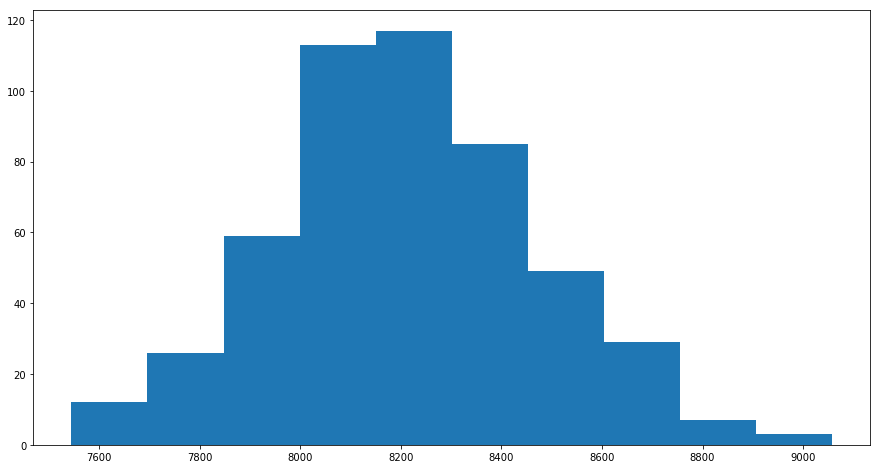

In [12]:
multi_run(500, reverse_sequence_mutation, PMX, 250)

 249    11.10542107 7912.25590410 7912.25590410 7912.25590410   0.00000000


 249    11.18818212 7770.65040510 7770.65040510 7770.65040510   0.00000000


 249    11.32144713 7942.83455241 7942.83455241 7942.83455241   0.00000000


 249    11.16834807 8028.64919130 8028.64919130 8028.64919130   0.00000000


 249    11.13198495 8150.13625030 8150.13625030 8150.13625030   0.00000000


 249    11.10697222 8358.78690827 8358.78690827 8358.78690827   0.00000000


 249    11.14060402 8390.76570251 8390.76570251 8390.76570251   0.00000000


 249    11.12004805 8007.95472148 8007.95472148 8007.95472148   0.00000000


 249    11.13033509 8687.28765754 8687.28765754 8687.28765754   0.00000000


 249    11.19681907 8108.95775109 8108.95775109 8108.95775109   0.00000000


 249    11.23199797 7965.48449759 7965.48449759 7965.48449759   0.00000000


 249    11.09908104 8042.64720568 8042.64720568 8042.64720568   0.00000000


 249    11.09714985 7937.50940252 7937.50940252 7937.50940252   0.00000000


 249    11.10938406 8534.71416733 8534.71416733 8534.71416733   0.00000000


 249    11.19020486 7974.84907804 7974.84907804 7974.84907804   0.00000000


 249    11.12657595 8557.99391556 8557.99391556 8557.99391556   0.00000000


 249    11.12399292 8537.94007429 8537.94007429 8537.94007429   0.00000000


 249    11.20947194 8491.10184414 8491.10184414 8491.10184414   0.00000000


 249    11.13356113 8402.20618845 8402.20618845 8402.20618845   0.00000000


 249    11.13169599 8275.90173812 8275.90173812 8275.90173812   0.00000000


 249    11.11494803 8025.16052532 8025.16052532 8025.16052532   0.00000000


 249    11.07920980 8069.90447846 8069.90447846 8069.90447846   0.00000000


 249    11.11479807 8024.27921553 8024.27921553 8024.27921553   0.00000000


 249    11.11543608 8309.81993760 8309.81993760 8309.81993760   0.00000000


 249    11.14843512 8251.18088783 8251.18088783 8251.18088783   0.00000000


 249    11.10361004 8098.88174444 8098.88174444 8098.88174444   0.00000000


 249    11.15077519 8266.07342802 8266.07342802 8266.07342802   0.00000000


 249    11.11079812 8327.29377283 8327.29377283 8327.29377283   0.00000000


 249    11.11664295 8597.81676199 8597.81676199 8597.81676199   0.00000000


 249    11.14960194 8136.50547088 8136.50547088 8136.50547088   0.00000000


 249    11.30085111 8431.94333192 8431.94333192 8431.94333192   0.00000000


 249    11.21536279 8202.09933457 8202.09933457 8202.09933457   0.00000000


 249    11.11633897 8038.35182028 8038.35182028 8038.35182028   0.00000000


 249    11.13723803 8346.94882644 8346.94882644 8346.94882644   0.00000000


 249    11.13837695 8046.88428523 8046.88428523 8046.88428523   0.00000000


 249    11.11588287 8381.92940172 8381.92940172 8381.92940172   0.00000000


 249    11.16014004 8178.28972455 8178.28972455 8178.28972455   0.00000000


 249    11.08311200 8052.05760799 8052.05760799 8052.05760799   0.00000000


 249    11.21657586 8006.34466448 8006.34466448 8006.34466448   0.00000000


 249    11.21915603 7932.21503816 7932.21503816 7932.21503816   0.00000000


 249    11.20770884 8062.79305416 8062.79305416 8062.79305416   0.00000000


 249    11.09273696 8120.05760652 8120.05760652 8120.05760652   0.00000000


 249    11.17180920 8028.87368260 8028.87368260 8028.87368260   0.00000000


 249    11.25772119 8107.82091428 8107.82091428 8107.82091428   0.00000000


 249    11.38608098 8348.34120201 8348.34120201 8348.34120201   0.00000000


 249    11.29619098 8203.77991953 8203.77991953 8203.77991953   0.00000000


 249    11.23641801 8427.24088712 8427.24088712 8427.24088712   0.00000000


 249    11.12804198 8532.75254864 8532.75254864 8532.75254864   0.00000000


 249    11.14916801 7823.12339297 7823.12339297 7823.12339297   0.00000000


 249    11.13352799 8175.16841426 8175.16841426 8175.16841426   0.00000000


 249    11.11313605 7859.09379998 7859.09379998 7859.09379998   0.00000000


 249    11.20257282 8276.79640883 8276.79640883 8276.79640883   0.00000000


 249    11.21716595 8263.03674809 8263.03674809 8263.03674809   0.00000000


 249    11.21044779 8140.51820569 8140.51820569 8140.51820569   0.00000000


 249    11.32487917 8512.95441015 8512.95441015 8512.95441015   0.00000000


 249    11.11680007 8548.78254018 8548.78254018 8548.78254018   0.00000000


 249    11.10842395 8065.03075849 8065.03075849 8065.03075849   0.00000000


 249    11.09446716 8200.83794659 8200.83794659 8200.83794659   0.00000000


 249    11.12130904 8265.10266673 8265.10266673 8265.10266673   0.00000000


 249    11.10758591 8479.43171402 8479.43171402 8479.43171402   0.00000000


 249    11.13408089 7932.09778529 7932.09778529 7932.09778529   0.00000000


 249    11.21057510 8177.91514452 8177.91514452 8177.91514452   0.00000000


 249    11.12108421 7837.13226593 7837.13226593 7837.13226593   0.00000000


 249    11.14107203 8346.99109863 8346.99109863 8346.99109863   0.00000000


 249    11.15178704 8082.17876053 8082.17876053 8082.17876053   0.00000000


 249    11.15483499 7965.48901537 7965.48901537 7965.48901537   0.00000000


 249    11.20500898 8255.78751674 8255.78751674 8255.78751674   0.00000000


 249    11.31928205 7903.79988326 7903.79988326 7903.79988326   0.00000000


 249    11.17809010 8141.93294223 8141.93294223 8141.93294223   0.00000000


 249    11.10770988 8135.79017253 8135.79017253 8135.79017253   0.00000000


 249    11.15114498 8231.30025496 8231.30025496 8231.30025496   0.00000000


 249    11.09009099 7866.14482358 7866.14482358 7866.14482358   0.00000000


 249    11.14435887 8137.85317593 8137.85317593 8137.85317593   0.00000000


 249    11.32577395 8458.06532596 8458.06532596 8458.06532596   0.00000000


 249    11.22189999 8115.92812171 8115.92812171 8115.92812171   0.00000000


 249    11.10472894 8090.68503833 8090.68503833 8090.68503833   0.00000000


 249    11.13135409 8120.93291433 8120.93291433 8120.93291433   0.00000000


 249    11.14111304 7889.54051182 7889.54051182 7889.54051182   0.00000000


 249    11.13335609 8684.22739960 8684.22739960 8684.22739960   0.00000000


 249    11.11376715 8107.47714492 8107.47714492 8107.47714492   0.00000000


 249    11.10824609 8133.10181107 8133.10181107 8133.10181107   0.00000000


 249    11.14218998 7903.27584414 7903.27584414 7903.27584414   0.00000000


 249    11.22090721 8521.45265407 8521.45265407 8521.45265407   0.00000000


 249    11.12891197 8036.20079843 8036.20079843 8036.20079843   0.00000000


 249    11.24252105 7986.17422429 7986.17422429 7986.17422429   0.00000000


 249    11.26848006 8132.91627982 8132.91627982 8132.91627982   0.00000000


 249    11.16573286 8136.23566059 8136.23566059 8136.23566059   0.00000000


 249    11.10196114 8256.12186561 8256.12186561 8256.12186561   0.00000000


 249    11.12454605 8108.43171489 8108.43171489 8108.43171489   0.00000000


 249    11.12323213 7886.72706849 7886.72706849 7886.72706849   0.00000000


 249    11.12907410 8523.64801221 8523.64801221 8523.64801221   0.00000000


 249    11.23712111 8105.73989784 8105.73989784 8105.73989784   0.00000000


 249    11.25271893 8523.44552429 8523.44552429 8523.44552429   0.00000000


 249    11.25583506 7629.87246153 7629.87246153 7629.87246153   0.00000000


 249    11.14626408 7940.15868009 7940.15868009 7940.15868009   0.00000000


 249    11.28527808 8628.94443111 8628.94443111 8628.94443111   0.00000000


 249    11.43708992 7905.76376759 7905.76376759 7905.76376759   0.00000000


 249    11.21821594 8086.61378854 8086.61378854 8086.61378854   0.00000000


 249    11.21663904 8430.59420054 8430.59420054 8430.59420054   0.00000000


 249    11.14421391 7990.53903711 7990.53903711 7990.53903711   0.00000000


 249    11.14399195 8477.90911570 8477.90911570 8477.90911570   0.00000000


 249    11.11775398 8257.59775532 8257.59775532 8257.59775532   0.00000000


 249    11.15237999 7687.95766715 7687.95766715 7687.95766715   0.00000000


 249    11.15919709 8257.51172172 8257.51172172 8257.51172172   0.00000000


 249    11.13521194 8003.67100075 8003.67100075 8003.67100075   0.00000000


 249    11.16322708 8437.03296852 8437.03296852 8437.03296852   0.00000000


 249    11.21506500 8042.93439343 8042.93439343 8042.93439343   0.00000000


 249    11.22674704 7988.23159433 7988.23159433 7988.23159433   0.00000000


 249    11.24674892 8006.55070700 8006.55070700 8006.55070700   0.00000000


 249    11.27967978 7891.35605436 7891.35605436 7891.35605436   0.00000000


 249    11.26218009 8642.29008490 8642.29008490 8642.29008490   0.00000000


 249    11.19201899 7994.53445791 7994.53445791 7994.53445791   0.00000000


 249    11.13550210 8470.02180935 8470.02180935 8470.02180935   0.00000000


 249    11.10503793 8067.11838950 8067.11838950 8067.11838950   0.00000000


 249    11.21130300 8098.09906250 8098.09906250 8098.09906250   0.00000000


 249    11.24262691 7800.27595226 7800.27595226 7800.27595226   0.00000000


 249    11.17331600 8472.60224481 8472.60224481 8472.60224481   0.00000000


 249    11.13839793 7900.80268165 7900.80268165 7900.80268165   0.00000000


 249    11.25398302 8371.83755759 8371.83755759 8371.83755759   0.00000000


 249    11.36448884 8266.02801033 8266.02801033 8266.02801033   0.00000000


 249    11.29168606 8431.95217973 8431.95217973 8431.95217973   0.00000000


 249    11.12814617 8524.06725096 8524.06725096 8524.06725096   0.00000000


 249    11.13598585 8510.50248083 8510.50248083 8510.50248083   0.00000000


 249    11.11328292 8341.11454123 8341.11454123 8341.11454123   0.00000000


 249    11.11491799 7903.77022877 7903.77022877 7903.77022877   0.00000000


 249    11.13976002 8254.80855686 8254.80855686 8254.80855686   0.00000000


 249    11.12300611 7832.02245380 7832.02245380 7832.02245380   0.00000000


 249    11.13043880 7977.87401361 7977.87401361 7977.87401361   0.00000000


 249    11.11241388 8270.60384923 8270.60384923 8270.60384923   0.00000000


 249    11.11923695 8585.46375914 8585.46375914 8585.46375914   0.00000000


 249    11.14270210 8031.12540396 8031.12540396 8031.12540396   0.00000000


 249    11.13049793 8070.66208213 8070.66208213 8070.66208213   0.00000000


 249    11.69249797 8135.52909496 8135.52909496 8135.52909496   0.00000000


 249    12.42721796 7909.88771748 7909.88771748 7909.88771748   0.00000000


 249    11.25988483 8396.98842816 8396.98842816 8396.98842816   0.00000000


 249    11.15860105 8073.55334403 8073.55334403 8073.55334403   0.00000000


 249    11.15447593 7848.54214383 7848.54214383 7848.54214383   0.00000000


 249    11.11433005 8316.43432663 8316.43432663 8316.43432663   0.00000000


 249    11.12120914 8271.41931086 8271.41931086 8271.41931086   0.00000000


 249    11.13332415 8107.03619120 8107.03619120 8107.03619120   0.00000000


 249    11.12027407 8449.00258848 8449.00258848 8449.00258848   0.00000000


 249    11.13208508 7658.95832038 7658.95832038 7658.95832038   0.00000000


 249    11.17929101 8314.10591391 8314.10591391 8314.10591391   0.00000000


 249    11.11362910 7757.96044927 7757.96044927 7757.96044927   0.00000000


 249    11.16208410 8748.47982334 8748.47982334 8748.47982334   0.00000000


 249    11.15201616 8055.36298952 8055.36298952 8055.36298952   0.00000000


 249    11.21349597 8597.81614517 8597.81614517 8597.81614517   0.00000000


 249    11.09155989 7791.66766673 7791.66766673 7791.66766673   0.00000000


 249    11.12474608 8038.17783649 8038.17783649 8038.17783649   0.00000000


 249    11.09808087 8849.46399779 8849.46399779 8849.46399779   0.00000000


 249    11.12919402 8489.52356994 8489.52356994 8489.52356994   0.00000000


 249    11.11667991 8181.31103966 8184.49775596 8194.47928883   5.63988595


 249    11.11939597 8152.50330996 8152.50330996 8152.50330996   0.00000000


 249    11.28928590 8262.54217110 8262.54217110 8262.54217110   0.00000000


 249    11.30416512 8458.17411263 8458.17411263 8458.17411263   0.00000000


 249    11.32441711 8707.09957159 8707.09957159 8707.09957159   0.00000000


 249    12.49606299 8258.13595969 8258.13595969 8258.13595969   0.00000000


 249    11.10058689 8002.37043797 8002.37043797 8002.37043797   0.00000000


 249    11.15550089 8158.35937416 8158.35937416 8158.35937416   0.00000000


 249    11.12846899 7678.90035321 7678.90035321 7678.90035321   0.00000000


 249    11.16393900 8499.91853974 8499.91853974 8499.91853974   0.00000000


 249    11.13359594 8782.63798863 8782.63798863 8782.63798863   0.00000000


 249    11.12097716 8058.31609874 8058.31609874 8058.31609874   0.00000000


 249    11.09261894 8470.30736330 8470.30736330 8470.30736330   0.00000000


 249    11.11257219 8254.57173544 8254.57173544 8254.57173544   0.00000000


 249    11.16270590 8211.00855300 8211.00855300 8211.00855300   0.00000000


 249    11.16974211 8789.81072711 8789.81072711 8789.81072711   0.00000000


 249    11.15191412 8346.19813977 8346.19813977 8346.19813977   0.00000000


 249    11.19451690 8378.55252784 8378.55252784 8378.55252784   0.00000000


 249    11.17239714 8343.06125304 8343.06125304 8343.06125304   0.00000000


 249    11.18123794 7972.51551386 7972.51551386 7972.51551386   0.00000000


 249    11.19321585 8233.51362322 8233.51362322 8233.51362322   0.00000000


 249    11.13753295 7842.44083931 7842.44083931 7842.44083931   0.00000000


 249    11.10401797 8393.64227832 8393.64227832 8393.64227832   0.00000000


 249    11.11718488 8214.04697085 8214.04697085 8214.04697085   0.00000000


 249    11.12957406 8207.77091832 8207.77091832 8207.77091832   0.00000000


 249    11.13936090 8136.46589033 8136.46589033 8136.46589033   0.00000000


 249    11.20818901 7919.62613059 7919.62613059 7919.62613059   0.00000000


 249    11.24494314 7777.33231128 7777.33231128 7777.33231128   0.00000000


 249    11.25349903 8245.04774878 8245.04774878 8245.04774878   0.00000000


 249    11.26785088 8216.76305132 8216.76305132 8216.76305132   0.00000000


 249    11.13113880 7780.29344888 7780.29344888 7780.29344888   0.00000000


 249    11.14574003 8023.76481054 8023.76481054 8023.76481054   0.00000000


 249    11.18126392 8207.34637740 8207.34637740 8207.34637740   0.00000000


 249    11.19452810 7794.75761367 7794.75761367 7794.75761367   0.00000000


 249    11.20625401 8478.21813410 8478.21813410 8478.21813410   0.00000000


 249    11.15156102 7767.86363763 7767.86363763 7767.86363763   0.00000000


 249    11.17602301 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249    11.31547904 8425.15361766 8425.15361766 8425.15361766   0.00000000


 249    11.31346989 8676.80539563 8676.80539563 8676.80539563   0.00000000


 249    11.15375710 8342.83870834 8342.83870834 8342.83870834   0.00000000


 249    11.11616802 8607.29810707 8607.29810707 8607.29810707   0.00000000


 249    11.14346504 8367.11368743 8367.11368743 8367.11368743   0.00000000


 249    11.13305616 8254.60478335 8254.60478335 8254.60478335   0.00000000


 249    11.14130807 8553.39522409 8553.39522409 8553.39522409   0.00000000


 249    11.14230800 7948.46768097 7948.46768097 7948.46768097   0.00000000


 249    11.18368816 7770.77939238 7770.77939238 7770.77939238   0.00000000


 249    11.17674708 8025.58560123 8025.58560123 8025.58560123   0.00000000


 249    11.22072196 8042.48476588 8042.48476588 8042.48476588   0.00000000


 249    11.10583305 8085.69788329 8085.69788329 8085.69788329   0.00000000


 249    11.13359308 8623.01585021 8623.01585021 8623.01585021   0.00000000


 249    11.14353085 8699.81592836 8699.81592836 8699.81592836   0.00000000


 249    11.16559696 7870.51065460 7870.51065460 7870.51065460   0.00000000


 249    11.12241507 7974.28549340 7974.28549340 7974.28549340   0.00000000


 249    11.16209102 8084.52406910 8084.52406910 8084.52406910   0.00000000


 249    11.12600112 8225.83215918 8225.83215918 8225.83215918   0.00000000


 249    15.26841307 8313.69683471 8313.69683471 8313.69683471   0.00000000


 249    11.18431497 8300.84426390 8300.84426390 8300.84426390   0.00000000


 249    11.25924015 8446.99457097 8446.99457097 8446.99457097   0.00000000


 249    11.31475592 7926.35623430 7926.35623430 7926.35623430   0.00000000


 249    11.30738497 8421.53188155 8421.53188155 8421.53188155   0.00000000


 249    11.31984305 8527.17044500 8527.17044500 8527.17044500   0.00000000


 249    11.25561190 7997.97689696 7997.97689696 7997.97689696   0.00000000


 249    11.12348890 8700.98979556 8700.98979556 8700.98979556   0.00000000


 249    11.12977982 8423.40067915 8423.40067915 8423.40067915   0.00000000


 249    11.13418412 8477.73769308 8477.73769308 8477.73769308   0.00000000


 249    11.14643383 8801.35186676 8801.35186676 8801.35186676   0.00000000


 249    11.13699412 8115.55902042 8115.55902042 8115.55902042   0.00000000


 249    11.17590690 7863.33261099 7863.33261099 7863.33261099   0.00000000


 249    11.12071204 7968.27851231 7968.27851231 7968.27851231   0.00000000


 249    11.17513704 8499.98314992 8499.98314992 8499.98314992   0.00000000


 249    11.11779690 8236.28744278 8236.28744278 8236.28744278   0.00000000


 249    11.10425305 8084.52181633 8084.52181633 8084.52181633   0.00000000


 249    11.13254690 8091.05581540 8091.05581540 8091.05581540   0.00000000


 249    11.13678813 7960.34311250 7960.34311250 7960.34311250   0.00000000


 249    11.11299491 8242.77324418 8242.77324418 8242.77324418   0.00000000


 249    11.38968682 8563.40975189 8563.40975189 8563.40975189   0.00000000


 249    11.13676405 8225.40211570 8225.40211570 8225.40211570   0.00000000


 249    11.17807913 8218.39406294 8218.39406294 8218.39406294   0.00000000


 249    11.14354491 8521.60788348 8521.60788348 8521.60788348   0.00000000


 249    11.18369699 8403.34955018 8403.34955018 8403.34955018   0.00000000


 249    11.11043692 7736.34670258 7736.34670258 7736.34670258   0.00000000


 249    11.11250496 8473.22339979 8473.22339979 8473.22339979   0.00000000


 249    11.11925697 8136.14271868 8136.14271868 8136.14271868   0.00000000


 249    11.18161297 8427.32996787 8427.32996787 8427.32996787   0.00000000


 249    11.12640500 8012.94524801 8012.94524801 8012.94524801   0.00000000


 249    11.16362500 8414.97079381 8414.97079381 8414.97079381   0.00000000


 249    15.37220311 8362.30165454 8362.30165454 8362.30165454   0.00000000


 249    13.55165505 7799.00444822 7799.00444822 7799.00444822   0.00000000


 249    11.14468002 8197.83489393 8197.83489393 8197.83489393   0.00000000


 249    11.18538499 8275.34750696 8275.34750696 8275.34750696   0.00000000


 249    11.15661597 8185.43620091 8185.43620091 8185.43620091   0.00000000


 249    11.14806604 8302.57310757 8302.57310757 8302.57310757   0.00000000


 249    11.15066099 8486.97409209 8486.97409209 8486.97409209   0.00000000


 249    11.15342903 8264.26918079 8264.26918079 8264.26918079   0.00000000


 249    11.11816597 8308.60824424 8308.60824424 8308.60824424   0.00000000


 249    11.11148500 8146.52555052 8146.52555052 8146.52555052   0.00000000


 249    11.16215611 8043.59676675 8043.59676675 8043.59676675   0.00000000


 249    11.13440704 8194.22664030 8194.22664030 8194.22664030   0.00000000


 249    11.12253499 8053.17780253 8053.17780253 8053.17780253   0.00000000


 249    11.82106805 8099.99122733 8099.99122733 8099.99122733   0.00000000


 249    11.11173487 8244.87872365 8244.87872365 8244.87872365   0.00000000


 249    11.43951178 7926.81558231 7926.81558231 7926.81558231   0.00000000


 249    11.61005807 8222.16271515 8222.16271515 8222.16271515   0.00000000


 249    11.54030204 8087.73061787 8087.73061787 8087.73061787   0.00000000


 249    11.46777201 8285.27282936 8285.27282936 8285.27282936   0.00000000


 249    11.32571197 8278.38358156 8278.38358156 8278.38358156   0.00000000


 249    11.35338998 8035.99582979 8035.99582979 8035.99582979   0.00000000


 249    11.30423403 7943.03895397 7943.03895397 7943.03895397   0.00000000


 249    11.28889704 8109.34424326 8109.34424326 8109.34424326   0.00000000


 249    11.38809085 8078.75132562 8078.75132562 8078.75132562   0.00000000


 249    11.32634497 7988.35173485 7988.35173485 7988.35173485   0.00000000


 249    11.34898686 8221.31642655 8221.31642655 8221.31642655   0.00000000


 249    11.31528902 8459.93531436 8459.93531436 8459.93531436   0.00000000


 249    11.34636497 8174.87624817 8174.87624817 8174.87624817   0.00000000


 249    11.36592889 8026.57028043 8026.57028043 8026.57028043   0.00000000


 249    11.25735307 8148.90710564 8148.90710564 8148.90710564   0.00000000


 249    11.35279989 8209.29208162 8209.29208162 8209.29208162   0.00000000


 249    11.35204411 8334.64436901 8334.64436901 8334.64436901   0.00000000


 249    11.32290316 8336.57117901 8336.57117901 8336.57117901   0.00000000


 249    11.26456785 7961.76583884 7961.76583884 7961.76583884   0.00000000


 249    11.34728217 8150.24559033 8150.24559033 8150.24559033   0.00000000


 249    11.31251001 8265.96548602 8265.96548602 8265.96548602   0.00000000


 249    11.28304195 8027.20448491 8027.20448491 8027.20448491   0.00000000


 249    11.35208511 8181.65890955 8181.65890955 8181.65890955   0.00000000


 249    11.32090998 8043.63521846 8043.63521846 8043.63521846   0.00000000


 249    11.39166903 8009.01557818 8009.01557818 8009.01557818   0.00000000


 249    11.33992100 8574.12988145 8574.12988145 8574.12988145   0.00000000


 249    11.48131490 8327.66672970 8327.66672970 8327.66672970   0.00000000


 249    11.41322088 8245.94360800 8245.94360800 8245.94360800   0.00000000


 249    11.40869308 8606.49681628 8606.49681628 8606.49681628   0.00000000


 249    11.37207198 8165.60155114 8165.60155114 8165.60155114   0.00000000


 249    11.38006496 7799.13816116 7799.13816116 7799.13816116   0.00000000


 249    11.34494209 8397.92852139 8397.92852139 8397.92852139   0.00000000


 249    11.36934614 8160.57415374 8160.57415374 8160.57415374   0.00000000


 249    11.29474401 8033.91627931 8033.91627931 8033.91627931   0.00000000


 249    11.31147599 8034.63082644 8034.63082644 8034.63082644   0.00000000


 249    11.33736801 7974.58740388 7974.58740388 7974.58740388   0.00000000


 249    11.54774594 8125.97054377 8125.97054377 8125.97054377   0.00000000


 249    11.53128791 8280.64722929 8280.64722929 8280.64722929   0.00000000


 249    11.54698014 7838.80827807 7838.80827807 7838.80827807   0.00000000


 249    11.55339599 8117.04501986 8117.04501986 8117.04501986   0.00000000


 249    11.58711004 8137.02032421 8137.02032421 8137.02032421   0.00000000


 249    11.57052994 8005.45494171 8005.45494171 8005.45494171   0.00000000


 249    11.62504292 8530.97964116 8530.97964116 8530.97964116   0.00000000


 249    11.52930307 7734.11117972 7734.11117972 7734.11117972   0.00000000


 249    11.52628088 8827.33057139 8827.33057139 8827.33057139   0.00000000


 249    11.56996393 7928.63270170 7928.63270170 7928.63270170   0.00000000


 249    11.45920491 7826.65781247 7826.65781247 7826.65781247   0.00000000


 249    11.31405997 7925.92085949 7925.92085949 7925.92085949   0.00000000


 249    11.33552599 8137.43044075 8137.43044075 8137.43044075   0.00000000


 249    11.31165600 7905.58697756 7905.58697756 7905.58697756   0.00000000


 249    11.34607697 8181.47116894 8181.47116894 8181.47116894   0.00000000


 249    11.30625701 7991.29320983 7991.29320983 7991.29320983   0.00000000


 249    11.34306407 7828.34643748 7828.34643748 7828.34643748   0.00000000


 249    11.42797899 8370.53285101 8370.53285101 8370.53285101   0.00000000


 249    11.38278890 8417.62373035 8417.62373035 8417.62373035   0.00000000


 249    11.54859900 8098.41215088 8098.41215088 8098.41215088   0.00000000


 249    11.37733006 8365.87029766 8365.87029766 8365.87029766   0.00000000


 249    11.43609500 8313.71634964 8313.71634964 8313.71634964   0.00000000


 249    11.41142297 8147.42594262 8147.42594262 8147.42594262   0.00000000


 249    11.47716999 8018.56534312 8018.56534312 8018.56534312   0.00000000


 249    11.43741012 7929.03409447 7929.03409447 7929.03409447   0.00000000


 249    11.37393093 8202.37328455 8202.37328455 8202.37328455   0.00000000


 249    11.42318916 7769.28905336 7769.28905336 7769.28905336   0.00000000


 249    11.40695286 7904.65212159 7904.65212159 7904.65212159   0.00000000


 249    11.40601182 8558.12947248 8558.12947248 8558.12947248   0.00000000


 249    11.40623784 8388.93264276 8388.93264276 8388.93264276   0.00000000


 249    11.38033390 7808.89837920 7808.89837920 7808.89837920   0.00000000


 249    11.44938397 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249    11.49588513 8274.20564739 8274.20564739 8274.20564739   0.00000000


 249    11.42433000 8200.40999846 8200.40999846 8200.40999846   0.00000000


 249    11.46296716 7955.80181651 7955.80181651 7955.80181651   0.00000000


 249    11.38838291 8716.67927350 8716.67927350 8716.67927350   0.00000000


 249    11.36397886 8194.17829426 8194.17829426 8194.17829426   0.00000000


 249    11.40088296 8477.89813759 8477.89813759 8477.89813759   0.00000000


 249    11.38292623 7782.98443615 7782.98443615 7782.98443615   0.00000000


 249    11.39856291 8087.46690250 8087.46690250 8087.46690250   0.00000000


 249    11.38091803 8289.04274188 8289.04274188 8289.04274188   0.00000000


 249    11.58942318 8460.37192227 8460.37192227 8460.37192227   0.00000000


 249    11.50375414 8311.25522012 8311.25522012 8311.25522012   0.00000000


 249    11.78129792 7938.28978052 7938.28978052 7938.28978052   0.00000000


 249    11.30425096 8212.50449353 8212.50449353 8212.50449353   0.00000000


 249    11.24976492 7981.10803755 7981.10803755 7981.10803755   0.00000000


 249    11.24386382 8094.90559234 8094.90559234 8094.90559234   0.00000000


 249    11.26526690 8602.12503393 8602.12503393 8602.12503393   0.00000000


 249    11.26022315 7677.68268290 7677.68268290 7677.68268290   0.00000000


 249    13.01739001 8406.04950208 8406.04950208 8406.04950208   0.00000000


 249    11.29599595 8092.21806463 8092.21806463 8092.21806463   0.00000000


 249    11.28007722 8225.47309933 8225.47309933 8225.47309933   0.00000000


 249    11.33049297 8974.58096812 8974.58096812 8974.58096812   0.00000000


 249    11.26672888 7845.90730859 7845.90730859 7845.90730859   0.00000000


 249    11.30146480 7672.72265134 7672.72265134 7672.72265134   0.00000000


 249    11.27010298 8154.96102607 8154.96102607 8154.96102607   0.00000000


 249    11.23031807 8284.66507645 8284.66507645 8284.66507645   0.00000000


 249    11.30074716 8349.93130786 8349.93130786 8349.93130786   0.00000000


 249    11.32770205 8165.37911274 8165.37911274 8165.37911274   0.00000000


 249    11.24750495 8086.44969572 8086.44969572 8086.44969572   0.00000000


 249    11.26821923 8228.97903280 8228.97903280 8228.97903280   0.00000000


 249    11.22164893 8107.35629630 8107.35629630 8107.35629630   0.00000000


 249    11.26666999 8255.28440558 8255.28440558 8255.28440558   0.00000000


 249    11.23498297 7861.44254468 7861.44254468 7861.44254468   0.00000000


 249    11.24293399 8364.28803534 8364.28803534 8364.28803534   0.00000000


 249    11.26690984 7735.79838522 7735.79838522 7735.79838522   0.00000000


 249    11.27665114 8253.04415465 8253.04415465 8253.04415465   0.00000000


 249    11.30516195 8458.31376781 8458.31376781 8458.31376781   0.00000000


 249    11.25994682 7918.22798404 7918.22798404 7918.22798404   0.00000000


 249    11.25584507 8398.78560655 8398.78560655 8398.78560655   0.00000000


 249    11.27169609 8189.80945270 8189.80945270 8189.80945270   0.00000000


 249    11.23325014 8295.17643175 8295.17643175 8295.17643175   0.00000000


 249    13.08736300 8490.31729091 8490.31729091 8490.31729091   0.00000000


 249    11.40174294 7936.78183026 7936.78183026 7936.78183026   0.00000000


 249    11.27938890 8379.79810740 8379.79810740 8379.79810740   0.00000000


 249    11.30680609 8070.92070136 8070.92070136 8070.92070136   0.00000000


 249    11.22925901 8095.94657775 8095.94657775 8095.94657775   0.00000000


 249    11.26662517 8044.25188227 8044.25188227 8044.25188227   0.00000000


 249    11.30362701 8778.55730355 8778.55730355 8778.55730355   0.00000000


 249    11.23221612 8343.92743657 8343.92743657 8343.92743657   0.00000000


 249    11.28358793 8048.98586497 8048.98586497 8048.98586497   0.00000000


 249    11.47074318 8045.77626480 8045.77626480 8045.77626480   0.00000000


 249    11.32097387 8329.82780578 8329.82780578 8329.82780578   0.00000000


 249    11.27920413 8327.64436031 8327.64436031 8327.64436031   0.00000000


 249    11.27460313 7919.32685555 7919.32685555 7919.32685555   0.00000000


 249    11.27933192 8743.45356258 8743.45356258 8743.45356258   0.00000000


 249    11.32148194 7932.22102757 7932.22102757 7932.22102757   0.00000000


 249    11.28964806 8467.65012073 8467.65012073 8467.65012073   0.00000000


 249    11.34634995 8195.96769795 8195.96769795 8195.96769795   0.00000000


 249    11.39030790 8390.93211589 8390.93211589 8390.93211589   0.00000000


 249    11.28515005 8324.55023912 8324.55023912 8324.55023912   0.00000000


 249    11.30050492 8086.15525100 8086.15525100 8086.15525100   0.00000000


 249    11.59841013 8362.82351416 8362.82351416 8362.82351416   0.00000000


 249    13.35462499 7911.82256465 7911.82256465 7911.82256465   0.00000000


 249    11.32828999 8699.63150530 8699.63150530 8699.63150530   0.00000000


 249    12.98530698 8124.45518539 8124.45518539 8124.45518539   0.00000000


 249    11.25612116 8144.95037480 8144.95037480 8144.95037480   0.00000000


 249    12.93823695 8536.07176728 8536.07176728 8536.07176728   0.00000000


 249    14.60242105 8117.92893719 8117.92893719 8117.92893719   0.00000000


 249    11.36155820 8325.99807511 8325.99807511 8325.99807511   0.00000000


 249    11.63216496 8516.41515280 8516.41515280 8516.41515280   0.00000000


 249    11.61649203 7684.58291090 7684.58291090 7684.58291090   0.00000000


 249    11.45272803 8078.34812061 8078.34812061 8078.34812061   0.00000000


 249    11.45934486 8142.56011738 8142.56011738 8142.56011738   0.00000000


 249    11.31321788 8124.38221852 8124.38221852 8124.38221852   0.00000000


 249    11.32396197 7716.68587733 7716.68587733 7716.68587733   0.00000000


 249    11.43579602 8084.16298860 8084.16298860 8084.16298860   0.00000000


 249    11.69959307 8077.48324823 8077.48324823 8077.48324823   0.00000000


 249    12.46646190 8326.94455055 8326.94455055 8326.94455055   0.00000000


 249    15.78334022 8502.27290356 8502.27290356 8502.27290356   0.00000000


 249    15.75473619 7916.60606305 7916.60606305 7916.60606305   0.00000000


 249    11.53297091 7894.72276768 7894.72276768 7894.72276768   0.00000000


 249    11.56184506 8136.60308882 8136.60308882 8136.60308882   0.00000000


 249    11.50050306 8325.38888493 8325.38888493 8325.38888493   0.00000000


 249    11.59253597 8081.28939489 8081.28939489 8081.28939489   0.00000000


 249    11.62527394 8202.82762615 8202.82762615 8202.82762615   0.00000000


 249    11.56881809 8174.32616666 8174.32616666 8174.32616666   0.00000000


 249    11.59563398 8135.00593763 8135.00593763 8135.00593763   0.00000000


 249    11.54247212 8120.13925743 8120.13925743 8120.13925743   0.00000000


 249    11.58744287 7925.08109962 7925.08109962 7925.08109962   0.00000000


 249    11.64819884 7854.26453538 7854.26453538 7854.26453538   0.00000000


 249    11.56610394 8313.72598146 8313.72598146 8313.72598146   0.00000000


 249    11.70995998 8069.59396271 8069.59396271 8069.59396271   0.00000000


 249    11.66718292 8040.80588979 8040.80588979 8040.80588979   0.00000000


 249    11.74854422 8379.77055043 8379.77055043 8379.77055043   0.00000000


 249    11.68968391 8300.39379628 8300.39379628 8300.39379628   0.00000000


 249    11.64340520 8156.52560271 8156.52560271 8156.52560271   0.00000000


 249    11.72983885 8237.99856385 8237.99856385 8237.99856385   0.00000000


 249    11.62253594 8297.05395290 8297.05395290 8297.05395290   0.00000000


 249    11.48151302 7854.74716233 7854.74716233 7854.74716233   0.00000000


 249    11.45416808 7837.13226593 7837.13226593 7837.13226593   0.00000000


 249    11.62696600 7969.49040934 7969.49040934 7969.49040934   0.00000000


 249    11.62507486 8267.36468223 8267.36468223 8267.36468223   0.00000000


 249    11.59302306 8404.77924804 8404.77924804 8404.77924804   0.00000000


 249    11.39670300 8552.40609325 8552.40609325 8552.40609325   0.00000000


 249    11.50284719 7978.50897979 7978.50897979 7978.50897979   0.00000000


 249    11.45301199 8051.45963355 8051.45963355 8051.45963355   0.00000000


 249    11.39396501 8034.27315437 8034.27315437 8034.27315437   0.00000000


 249    11.43041992 8389.69836427 8389.69836427 8389.69836427   0.00000000


 249    11.17749000 8356.04788271 8356.04788271 8356.04788271   0.00000000


 249    11.11810088 7914.86837073 7914.86837073 7914.86837073   0.00000000


 249    11.10295200 8019.82943093 8019.82943093 8019.82943093   0.00000000


 249    11.13968992 8153.35545194 8153.35545194 8153.35545194   0.00000000


 249    11.09495091 8183.28853989 8183.28853989 8183.28853989   0.00000000


 249    11.12462091 8140.76749290 8140.76749290 8140.76749290   0.00000000


 249    11.31675100 8293.49634440 8293.49634440 8293.49634440   0.00000000


 249    11.28997111 7816.94514898 7816.94514898 7816.94514898   0.00000000


 249    11.23419905 8108.62092549 8108.62092549 8108.62092549   0.00000000


 249    11.33997607 8484.89940209 8484.89940209 8484.89940209   0.00000000


 249    11.22565389 8072.36722039 8072.36722039 8072.36722039   0.00000000


 249    11.21097183 8291.19825994 8291.19825994 8291.19825994   0.00000000


 249    11.19204783 8209.54650720 8209.54650720 8209.54650720   0.00000000


 249    11.21221685 8459.04642562 8459.04642562 8459.04642562   0.00000000


 249    11.18397284 8359.04322452 8359.04322452 8359.04322452   0.00000000


 249    11.19669008 8249.63659632 8249.63659632 8249.63659632   0.00000000


 249    11.12645388 8400.74166120 8400.74166120 8400.74166120   0.00000000


 249    11.14119911 8392.76840068 8392.76840068 8392.76840068   0.00000000


 249    11.12267590 8317.35635741 8317.35635741 8317.35635741   0.00000000


 249    11.13346696 8195.54250168 8195.54250168 8195.54250168   0.00000000


 249    11.14737916 8158.58785554 8158.58785554 8158.58785554   0.00000000


 249    11.11905718 8246.72648013 8246.72648013 8246.72648013   0.00000000


 249    11.14994311 8305.49654521 8305.49654521 8305.49654521   0.00000000


 249    11.13270903 8044.78141099 8044.78141099 8044.78141099   0.00000000


 249    11.11202407 8428.07504248 8428.07504248 8428.07504248   0.00000000


 249    11.13350892 7867.32440875 7867.32440875 7867.32440875   0.00000000


 249    11.11557698 8334.21767176 8334.21767176 8334.21767176   0.00000000


 249    11.17514586 8489.76063311 8489.76063311 8489.76063311   0.00000000


 249    11.15902400 8158.99320118 8158.99320118 8158.99320118   0.00000000


 249    11.13020492 8298.74189885 8298.74189885 8298.74189885   0.00000000


 249    11.13751602 8386.42964495 8386.42964495 8386.42964495   0.00000000


 249    11.11633301 8120.36280302 8120.36280302 8120.36280302   0.00000000


 249    11.11402988 8170.47489317 8170.47489317 8170.47489317   0.00000000


 249    11.15209007 8127.40949049 8127.40949049 8127.40949049   0.00000000


 249    11.23358393 7726.79909035 7726.79909035 7726.79909035   0.00000000


 249    11.18079305 8455.58270128 8455.58270128 8455.58270128   0.00000000


 249    11.22133207 8171.84106270 8171.84106270 8171.84106270   0.00000000


 249    11.14816713 8381.76884035 8381.76884035 8381.76884035   0.00000000


 249    11.12766099 8036.22934097 8036.22934097 8036.22934097   0.00000000


 249    11.13863277 8077.69945209 8077.69945209 8077.69945209   0.00000000


 249    11.12867999 8212.33532470 8212.33532470 8212.33532470   0.00000000


 249    11.13046408 8243.79096841 8243.79096841 8243.79096841   0.00000000


 249    11.14524198 8082.08340905 8082.08340905 8082.08340905   0.00000000


 249    11.07479405 8363.56209279 8363.56209279 8363.56209279   0.00000000


 249    11.11624789 8007.07954606 8007.07954606 8007.07954606   0.00000000


 249    11.13621402 8450.78658110 8450.78658110 8450.78658110   0.00000000


 249    11.10928082 8290.16561384 8290.16561384 8290.16561384   0.00000000


 249    11.13753700 8495.27219664 8495.27219664 8495.27219664   0.00000000


 249    11.12393689 8413.36178294 8413.36178294 8413.36178294   0.00000000


 249    11.12716794 8135.21930240 8135.21930240 8135.21930240   0.00000000


 249    11.10477710 7865.30210592 7865.30210592 7865.30210592   0.00000000


 249    11.12819386 7979.28967529 7979.28967529 7979.28967529   0.00000000


 249    11.16747308 8221.13902491 8221.13902491 8221.13902491   0.00000000


 249    11.23966408 8841.97817571 8841.97817571 8841.97817571   0.00000000


 249    11.14607692 7941.18850713 7941.18850713 7941.18850713   0.00000000


 249    11.39888692 8185.76638606 8185.76638606 8185.76638606   0.00000000


 249    11.29084182 8584.30701668 8584.30701668 8584.30701668   0.00000000


 249    11.28666401 8135.86128951 8135.86128951 8135.86128951   0.00000000


 249    11.29478192 7912.19327510 7912.19327510 7912.19327510   0.00000000


 249    11.59362793 8237.64677752 8237.64677752 8237.64677752   0.00000000


 249    14.65658307 8213.49125646 8213.49125646 8213.49125646   0.00000000


 249    11.10297394 8401.21015653 8401.21015653 8401.21015653   0.00000000


 249    11.14556813 7840.60621934 7840.60621934 7840.60621934   0.00000000


 249    11.09338307 8252.34751517 8252.34751517 8252.34751517   0.00000000


 249    11.10912800 7544.36590190 7544.36590190 7544.36590190   0.00000000


 249    12.78236604 8019.13855860 8019.13855860 8019.13855860   0.00000000


 249    11.10368896 8567.67284494 8567.67284494 8567.67284494   0.00000000


 249    11.12247014 8207.52040155 8207.52040155 8207.52040155   0.00000000


 249    11.18950701 8096.54613038 8096.54613038 8096.54613038   0.00000000


 249    11.28454208 8266.66638516 8266.66638516 8266.66638516   0.00000000


 249    11.39861608 8365.87594838 8365.87594838 8365.87594838   0.00000000


 249    11.38840199 8291.58742616 8291.58742616 8291.58742616   0.00000000


 249    11.11189413 8152.62721351 8152.62721351 8152.62721351   0.00000000



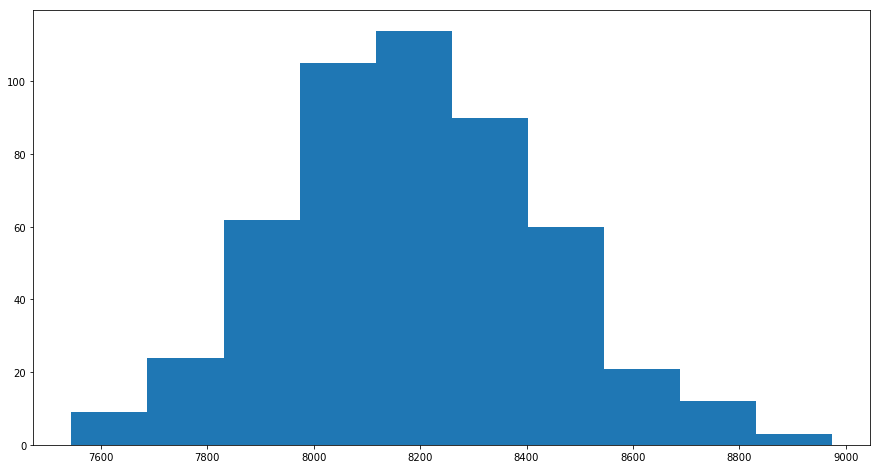

In [13]:
multi_run(500, reverse_sequence_mutationuence_mutationsequence_mutation, PPX, 250)